In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# product group and starting date

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [7]:
from bktest.backtest_grid_search import *

roll_name = 'hot'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=datetime.date(2023,4,28),
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d',
    shift_mode=2
)

if len(error_list) > 0:
    print(error_list)
    
print(df.tail(10))


product         AP                                                        \
code            c1                                                         
field        close contract      expiry    high     low      mth    open   
date                                                                       
2023-04-17  8225.0   AP2310  2023-10-20  8238.0  8056.0  24286.0  8080.0   
2023-04-18  8244.0   AP2310  2023-10-20  8293.0  8191.0  24286.0  8226.0   
2023-04-19  8408.0   AP2310  2023-10-20  8495.0  8223.0  24286.0  8253.0   
2023-04-20  8438.0   AP2310  2023-10-20  8479.0  8385.0  24286.0  8410.0   
2023-04-21  8458.0   AP2310  2023-10-20  8553.0  8310.0  24286.0  8438.0   
2023-04-24  8546.0   AP2310  2023-10-20  8738.0  8531.0  24286.0  8600.0   
2023-04-25  8514.0   AP2310  2023-10-20  8593.0  8401.0  24286.0  8493.0   
2023-04-26  8518.0   AP2310  2023-10-20  8576.0  8458.0  24286.0  8514.0   
2023-04-27  8515.0   AP2310  2023-10-20  8576.0  8430.0  24286.0  8504.0   
2023-04-28  

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


# strategy portfolio config

In [21]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.155, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0945, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0758, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0595, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0484, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.151, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.0844, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.22, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.502, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.420, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.527, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.163, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.147, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.143, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0406, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0381, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.0369, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.119, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.117, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.122, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.120, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.125, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.137, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.456, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.4, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

scenarios_test2 = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.1666, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.3989, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 1.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 1.0, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.0, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 1.0, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 1.0, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 1.0, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('custom', 'hc_rb_diff', 1.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'leader_lagger', 0.4, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


# run backtest for a portfolio group

In [9]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

In [10]:
holdings.keys()

dict_keys([])

In [29]:
holidays.China(years=2023).items()

dict_items([(datetime.date(2023, 1, 1), "New Year's Day"), (datetime.date(2023, 5, 1), 'Labour Day'), (datetime.date(2023, 1, 22), 'Chinese New Year (Spring Festival)'), (datetime.date(2023, 1, 23), 'Chinese New Year (Spring Festival)'), (datetime.date(2023, 10, 1), 'National Day'), (datetime.date(2023, 10, 2), 'National Day'), (datetime.date(2023, 4, 5), 'Tomb-Sweeping Day'), (datetime.date(2023, 6, 22), 'Dragon Boat Festival'), (datetime.date(2023, 9, 29), 'Mid-Autumn Festival'), (datetime.date(2023, 10, 3), 'National Day'), (datetime.date(2023, 1, 24), 'Chinese New Year (Spring Festival)')])

date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


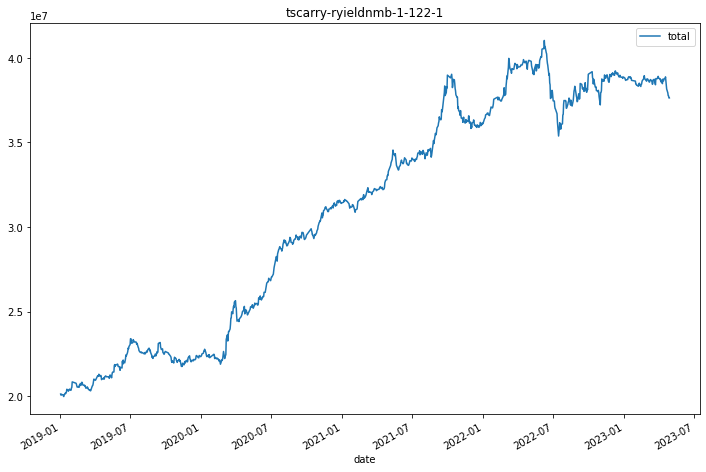

       sharpe        std  sortino
tenor                            
all      1.57  125329.86     2.22
6m      -0.25  156337.91    -0.44
1y      -0.59  223775.26    -0.95
2y       0.69  214847.23     1.11
3y       1.42  188842.57     2.20
4y       1.47  180110.75     2.29
5y       1.44  172023.94     2.23
6y       1.46  160251.94     2.21
7y       1.59  153693.74     2.41
8y       1.51  148650.10     2.28
9y       1.52  142154.04     2.27
10y      1.56  136575.41     2.30
11y      1.63  131836.09     2.39
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


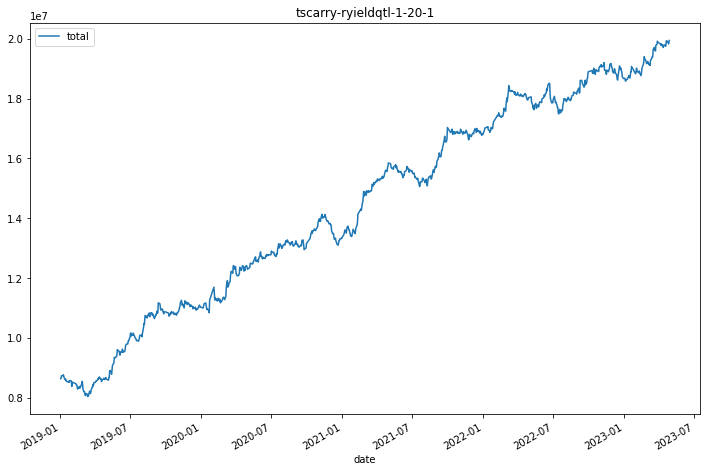

       sharpe       std  sortino
tenor                           
all      1.59  65287.16     2.54
6m       1.57  82960.26     2.58
1y       1.46  85966.26     2.26
2y       1.69  83157.46     2.79
3y       2.02  79575.30     3.40
4y       2.24  81261.32     3.94
5y       1.92  78875.08     3.37
6y       1.62  76649.43     2.77
7y       1.71  74799.90     2.94
8y       1.54  74066.20     2.57
9y       1.55  72156.65     2.57
10y      1.67  69875.49     2.72
11y      1.64  67729.02     2.64
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


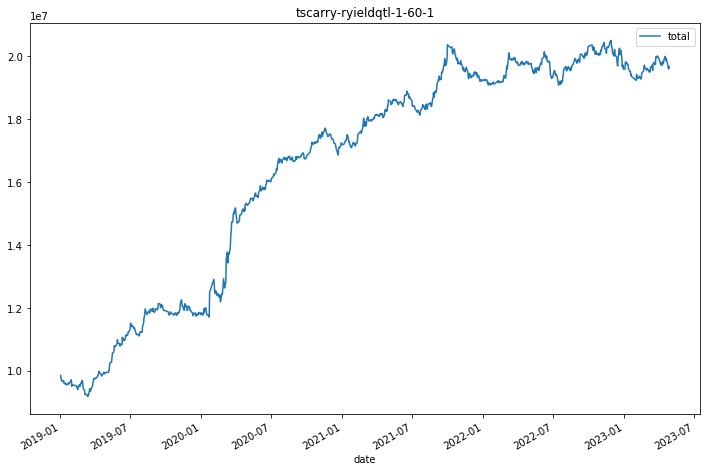

       sharpe       std  sortino
tenor                           
all      1.48  69276.99     2.36
6m      -0.47  95586.37    -0.81
1y      -0.06  87986.94    -0.11
2y       0.51  86237.52     0.92
3y       1.15  80680.81     1.99
4y       1.75  89666.47     3.21
5y       1.61  86375.41     2.87
6y       1.36  82394.93     2.36
7y       1.49  80227.46     2.58
8y       1.30  78623.14     2.19
9y       1.36  76851.60     2.26
10y      1.52  74387.41     2.48
11y      1.51  72004.27     2.44
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


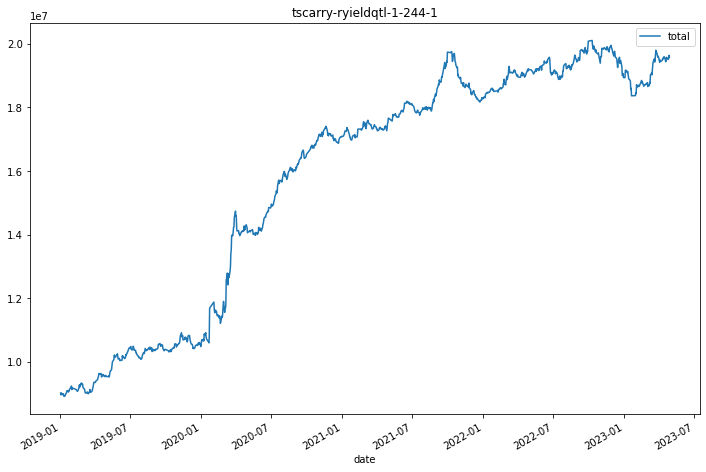

       sharpe       std  sortino
tenor                           
all      1.53  66905.41     2.32
6m      -0.08  98261.75    -0.12
1y       0.31  89232.93     0.49
2y       0.86  82660.09     1.36
3y       1.45  77546.36     2.29
4y       1.78  90608.10     3.00
5y       1.59  86276.02     2.64
6y       1.41  81453.48     2.32
7y       1.44  78792.35     2.37
8y       1.42  77532.02     2.29
9y       1.44  75649.39     2.33
10y      1.48  72948.50     2.38
11y      1.58  70598.37     2.52
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


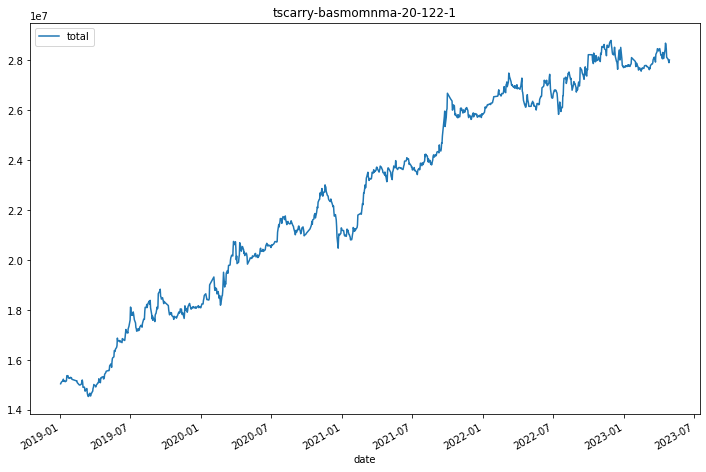

       sharpe        std  sortino
tenor                            
all      1.24  117665.63     1.80
6m      -0.08  142245.30    -0.12
1y       0.66  159449.21     1.13
2y       1.03  151722.02     1.68
3y       1.16  143232.03     1.86
4y       1.39  145326.23     2.22
5y       1.34  142690.03     2.13
6y       1.12  139103.02     1.75
7y       1.27  135153.53     1.98
8y       1.08  136927.30     1.65
9y       1.11  132272.67     1.69
10y      1.24  126887.21     1.86
11y      1.27  122808.95     1.89
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


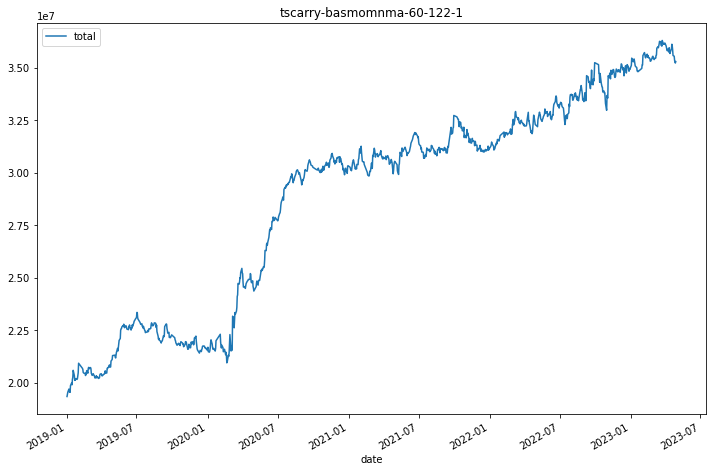

       sharpe        std  sortino
tenor                            
all      1.25  147551.76     1.88
6m       1.13  187707.48     2.56
1y       0.84  206217.20     1.61
2y       0.90  185351.34     1.65
3y       1.27  176033.93     2.26
4y       1.29  178119.18     2.25
5y       1.24  177262.96     2.04
6y       1.24  168647.70     2.02
7y       1.36  164504.44     2.23
8y       1.25  170360.43     2.01
9y       1.26  165236.30     2.00
10y      1.25  158975.31     1.96
11y      1.29  154976.68     2.02
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


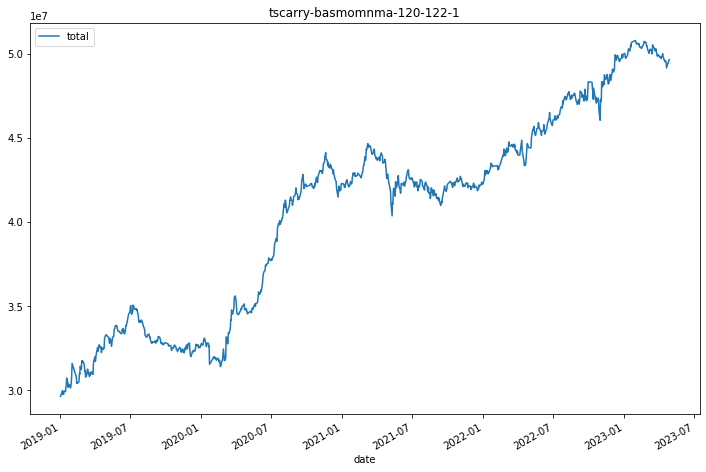

       sharpe        std  sortino
tenor                            
all      1.36  190148.17     2.01
6m       1.33  236397.44     2.38
1y       1.41  230430.56     2.49
2y       0.98  229474.70     1.63
3y       1.43  221647.09     2.29
4y       1.23  216282.86     1.90
5y       1.39  217741.01     2.16
6y       1.36  210672.62     2.12
7y       1.57  208049.46     2.45
8y       1.55  220256.79     2.43
9y       1.44  214526.33     2.27
10y      1.40  205751.06     2.17
11y      1.44  200255.89     2.21
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


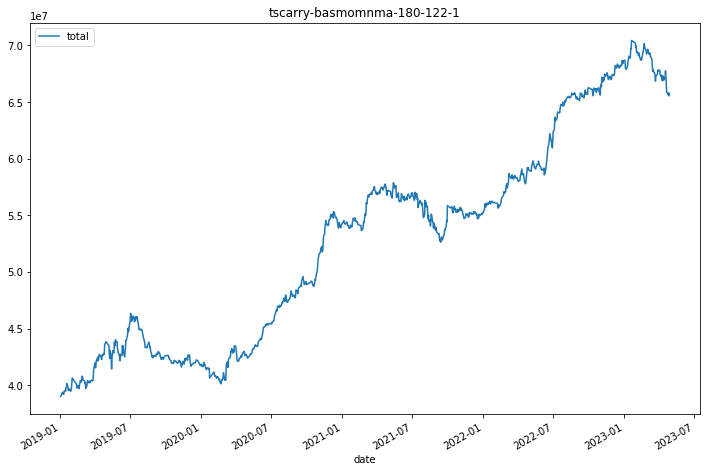

       sharpe        std  sortino
tenor                            
all      1.31  261345.50     1.88
6m      -0.20  304839.54    -0.35
1y       1.46  284333.13     2.52
2y       0.96  291666.45     1.63
3y       1.80  273933.60     2.91
4y       1.28  278990.52     2.04
5y       1.44  280880.26     2.32
6y       1.34  274239.97     2.10
7y       1.55  281738.77     2.46
8y       1.43  310653.59     2.24
9y       1.48  297447.73     2.28
10y      1.46  285590.38     2.23
11y      1.39  276266.57     2.11
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


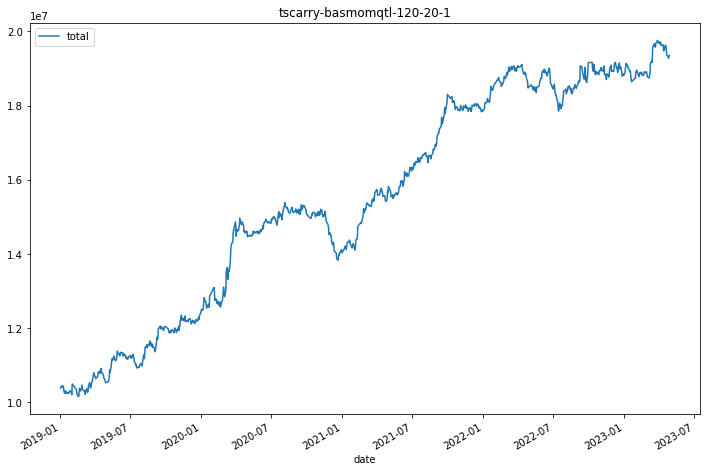

       sharpe       std  sortino
tenor                           
all      1.46  68988.79     2.38
6m       0.81  79544.69     1.22
1y       0.61  90537.90     0.94
2y       1.48  82977.21     2.37
3y       1.30  78425.26     2.12
4y       1.70  82504.02     2.84
5y       1.53  80199.38     2.58
6y       1.42  77454.19     2.35
7y       1.56  75612.44     2.60
8y       1.31  74355.18     2.17
9y       1.34  72746.39     2.21
10y      1.41  70439.99     2.30
11y      1.48  68369.11     2.39
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


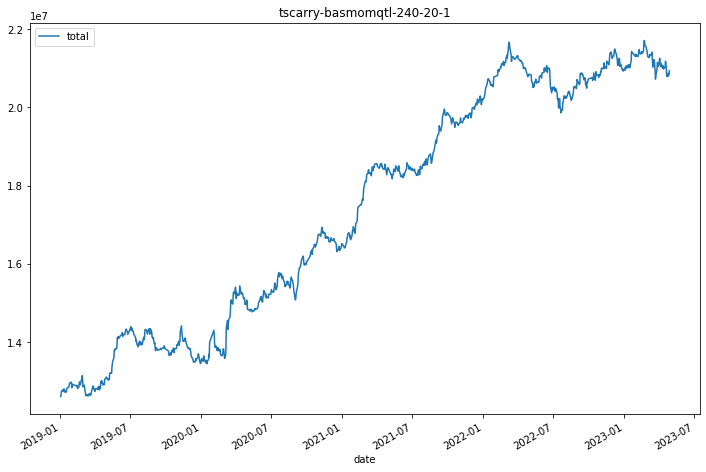

       sharpe       std  sortino
tenor                           
all      1.42  77186.33     2.31
6m       0.24  89263.54     0.38
1y       0.09  89410.29     0.14
2y       1.01  82125.06     1.58
3y       1.60  79462.78     2.56
4y       1.51  83590.97     2.54
5y       1.45  79639.16     2.45
6y       1.38  77144.81     2.29
7y       1.21  74999.15     2.01
8y       1.16  74836.51     1.87
9y       1.26  74334.51     2.06
10y      1.33  72247.68     2.16
11y      1.43  70509.42     2.32
date
2011-07-05    12820.512821
2011-07-06    12820.512821
2011-07-07    12820.512821
2011-07-08    12820.512821
2011-07-11    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2872, dtype: float64


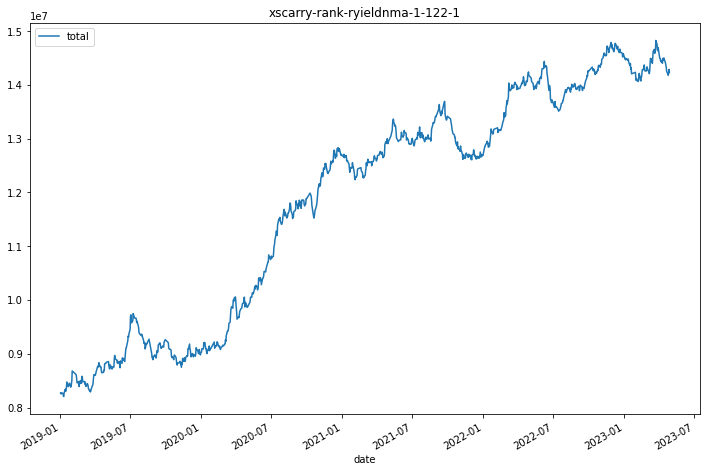

       sharpe       std  sortino
tenor                           
all      1.62  47647.18     2.53
6m      -0.29  58993.18    -0.55
1y       0.03  56911.28     0.05
2y       0.66  59557.29     1.04
3y       1.52  60522.62     2.51
4y       1.44  60239.00     2.42
5y       1.58  59006.76     2.67
6y       1.61  56804.61     2.68
7y       1.58  56078.51     2.65
8y       1.56  54543.39     2.59
9y       1.54  52656.90     2.52
10y      1.61  51125.28     2.61
11y      1.68  49171.02     2.66
date
2011-08-02    12820.512821
2011-08-03    12820.512821
2011-08-04    12820.512821
2011-08-05    12820.512821
2011-08-08    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2852, dtype: float64


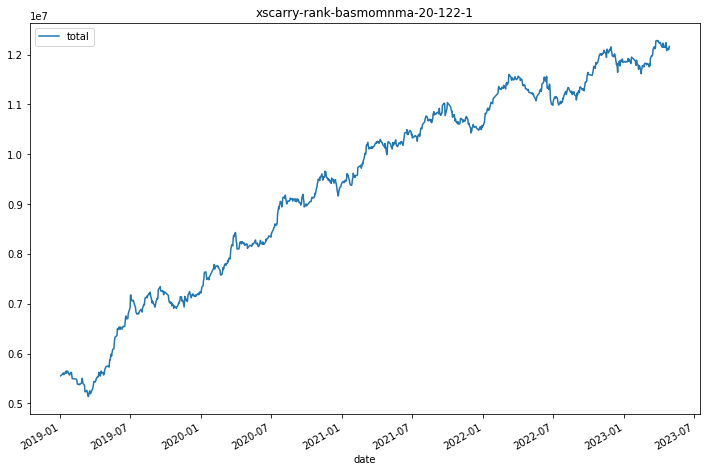

       sharpe       std  sortino
tenor                           
all      1.61  41382.20     2.44
6m       0.57  53578.01     0.91
1y       1.04  52888.32     1.54
2y       1.35  50844.87     1.99
3y       1.69  50254.65     2.54
4y       2.06  50616.97     3.24
5y       1.92  50047.73     2.97
6y       1.69  49378.70     2.62
7y       1.60  48299.33     2.51
8y       1.46  47015.44     2.28
9y       1.42  45504.05     2.23
10y      1.53  44051.57     2.37
11y      1.58  42437.87     2.42
date
2011-11-30    12820.512821
2011-12-01    12820.512821
2011-12-02    12820.512821
2011-12-05    12820.512821
2011-12-06    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2772, dtype: float64


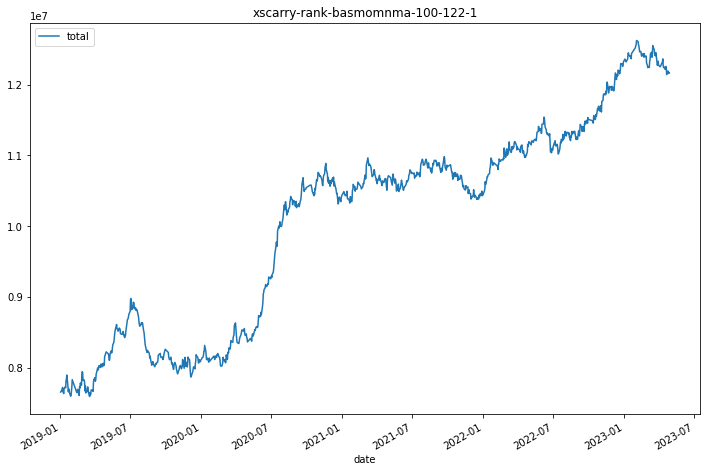

       sharpe       std  sortino
tenor                           
all      1.63  42180.08     2.57
6m       1.20  49794.00     2.01
1y       1.33  49969.29     2.24
2y       1.04  48931.50     1.78
3y       1.54  51236.46     2.58
4y       1.29  50135.88     2.15
5y       1.37  51527.25     2.26
6y       1.43  49939.02     2.34
7y       1.50  48910.26     2.49
8y       1.61  47680.72     2.66
9y       1.64  45954.07     2.67
10y      1.59  44444.49     2.58
11y      1.66  42792.08     2.63
date
2012-03-16    12820.512821
2012-03-19    12820.512821
2012-03-20    12820.512821
2012-03-21    12820.512821
2012-03-22    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2702, dtype: float64


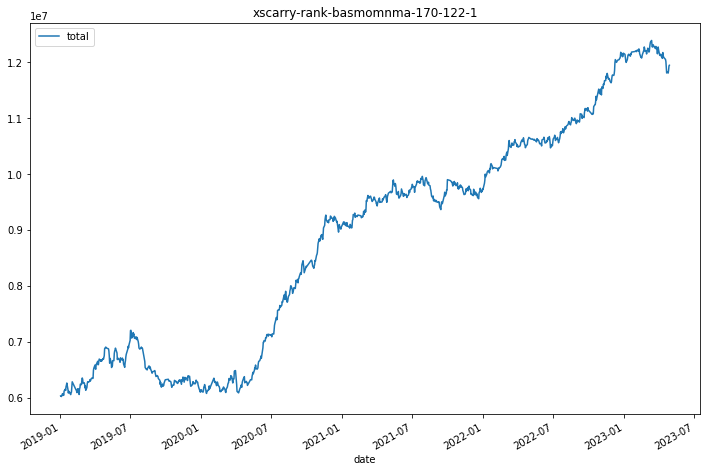

       sharpe       std  sortino
tenor                           
all      1.69  40889.38     2.68
6m       1.10  48685.22     1.93
1y       1.85  45754.55     3.32
2y       1.63  46771.97     2.99
3y       2.51  48195.99     4.44
4y       1.67  48665.56     2.89
5y       1.79  49420.60     3.00
6y       1.78  47553.40     2.94
7y       1.72  47058.78     2.88
8y       1.77  45759.27     2.92
9y       1.77  44021.66     2.88
10y      1.77  42665.29     2.86
11y      1.71  41068.79     2.72
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


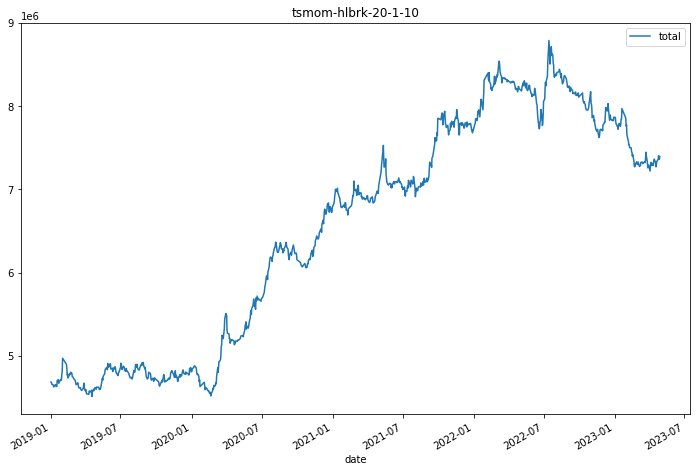

       sharpe       std  sortino
tenor                           
all      1.01  38292.77     1.45
6m      -1.73  47060.45    -2.33
1y      -0.99  54310.70    -1.37
2y       0.25  54712.08     0.37
3y       0.95  50269.05     1.38
4y       0.95  46924.66     1.38
5y       0.88  44458.44     1.30
6y       0.86  43239.32     1.27
7y       0.85  42771.64     1.30
8y       0.98  43216.34     1.45
9y       1.01  41994.94     1.49
10y      1.00  40610.50     1.46
11y      1.08  39599.43     1.59
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


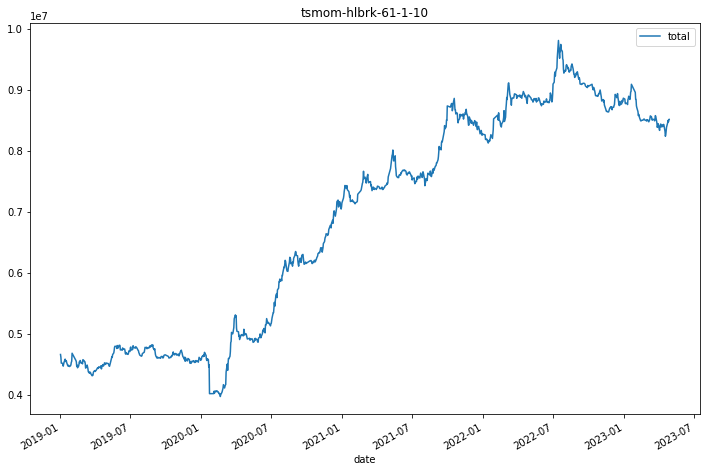

       sharpe       std  sortino
tenor                           
all      1.04  42541.79     1.46
6m      -1.13  46409.73    -1.54
1y      -0.46  53512.52    -0.62
2y       0.58  57628.08     0.89
3y       1.37  54748.69     2.13
4y       1.19  53867.21     1.62
5y       1.08  50556.93     1.49
6y       0.89  49094.48     1.26
7y       0.85  47538.61     1.22
8y       1.05  48101.79     1.50
9y       1.10  46705.46     1.56
10y      1.05  45079.66     1.49
11y      1.11  43959.16     1.56
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


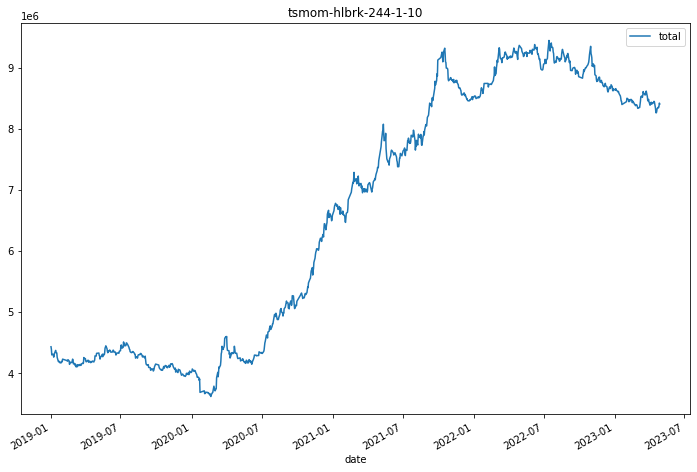

       sharpe       std  sortino
tenor                           
all      1.09  40379.65     1.49
6m      -2.25  41287.52    -3.02
1y      -1.28  44997.04    -1.77
2y       0.59  56404.37     0.88
3y       1.60  54650.73     2.40
4y       1.29  51222.11     1.90
5y       1.15  47467.47     1.66
6y       0.99  44688.57     1.42
7y       1.05  44664.82     1.54
8y       1.09  46333.97     1.59
9y       1.15  45072.50     1.66
10y      1.15  43670.24     1.66
11y      1.19  42538.00     1.71
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


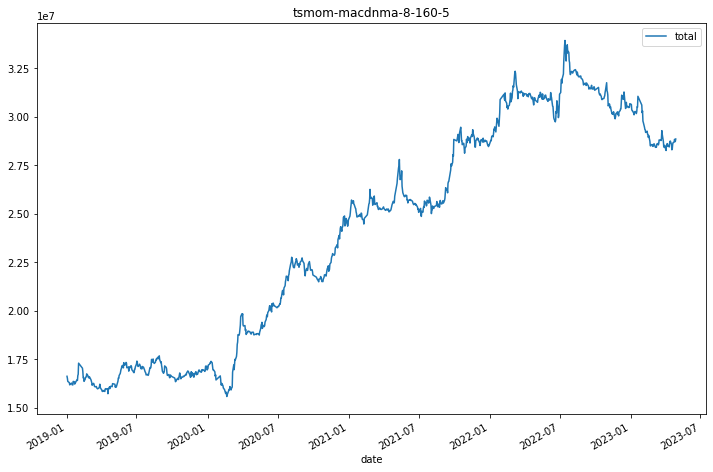

       sharpe        std  sortino
tenor                            
all      1.03  146590.99     1.46
6m      -1.60  188755.99    -2.09
1y      -0.64  213467.56    -0.87
2y       0.47  217656.30     0.70
3y       1.07  199681.51     1.56
4y       1.09  186742.96     1.61
5y       0.92  175645.71     1.36
6y       0.84  169514.70     1.25
7y       0.83  166952.14     1.26
8y       0.96  168991.54     1.43
9y       0.94  162257.02     1.39
10y      0.91  156444.67     1.34
11y      1.02  152871.29     1.50
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


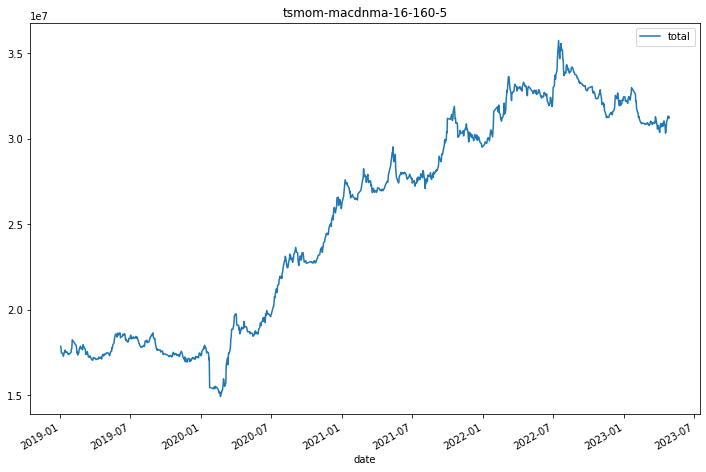

       sharpe        std  sortino
tenor                            
all      1.02  159590.35     1.40
6m      -0.89  180867.01    -1.24
1y      -0.55  202866.11    -0.76
2y       0.54  223503.87     0.81
3y       1.25  209718.35     1.87
4y       1.09  204835.68     1.47
5y       0.88  191683.66     1.21
6y       0.78  185027.83     1.10
7y       0.76  181762.54     1.09
8y       0.97  184177.82     1.38
9y       1.00  176797.62     1.41
10y      0.96  170252.92     1.34
11y      1.02  166238.32     1.42
date
2011-01-04    12820.512821
2011-01-05    12820.512821
2011-01-06    12820.512821
2011-01-07    12820.512821
2011-01-10    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2993, dtype: float64


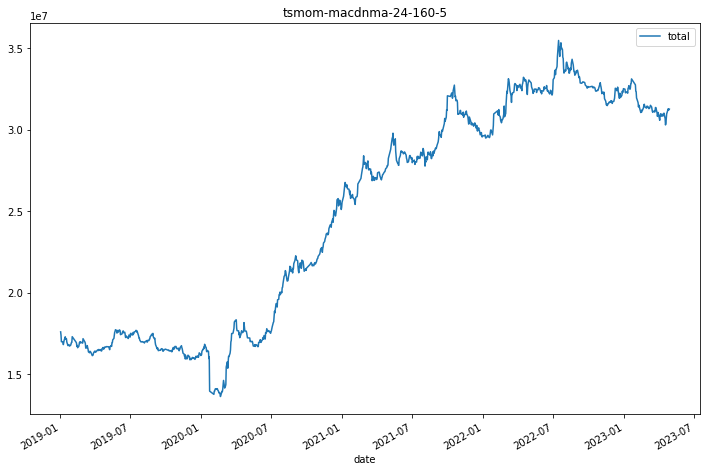

       sharpe        std  sortino
tenor                            
all      0.99  164537.66     1.32
6m      -0.97  171496.20    -1.37
1y      -0.51  197783.19    -0.70
2y       0.50  222427.22     0.75
3y       1.36  213821.40     2.08
4y       1.10  212420.59     1.45
5y       0.88  198160.23     1.16
6y       0.73  190853.35     0.98
7y       0.73  187486.24     1.00
8y       0.95  189548.52     1.31
9y       1.02  182393.21     1.39
10y      0.98  175677.93     1.34
11y      1.00  171206.35     1.36
date
2011-01-31    12820.512821
2011-02-01    12820.512821
2011-02-09    12820.512821
2011-02-10    12820.512821
2011-02-11    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2974, dtype: float64


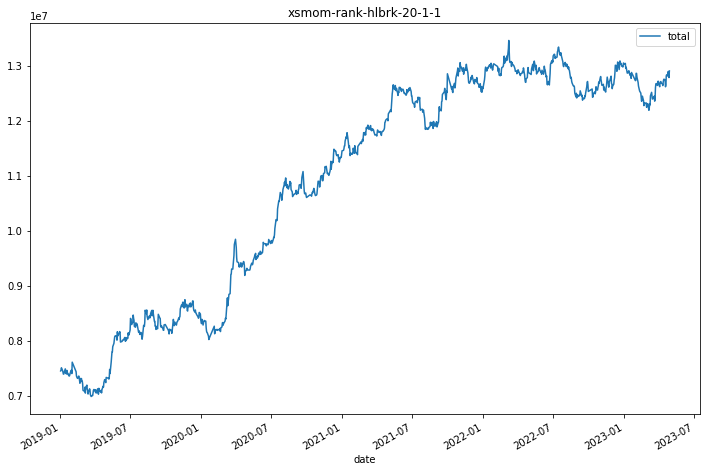

       sharpe       std  sortino
tenor                           
all      1.26  53810.66     1.99
6m       0.37  68599.57     0.69
1y      -0.06  66511.29    -0.10
2y       0.39  71110.92     0.68
3y       1.15  67742.42     1.89
4y       1.29  69515.09     2.17
5y       1.06  67253.12     1.77
6y       1.11  65430.85     1.85
7y       0.89  63472.58     1.47
8y       0.97  61518.96     1.60
9y       1.04  59950.98     1.72
10y      1.17  58058.60     1.91
11y      1.24  56072.94     1.99
date
2011-04-07    12820.512821
2011-04-08    12820.512821
2011-04-11    12820.512821
2011-04-12    12820.512821
2011-04-13    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2933, dtype: float64


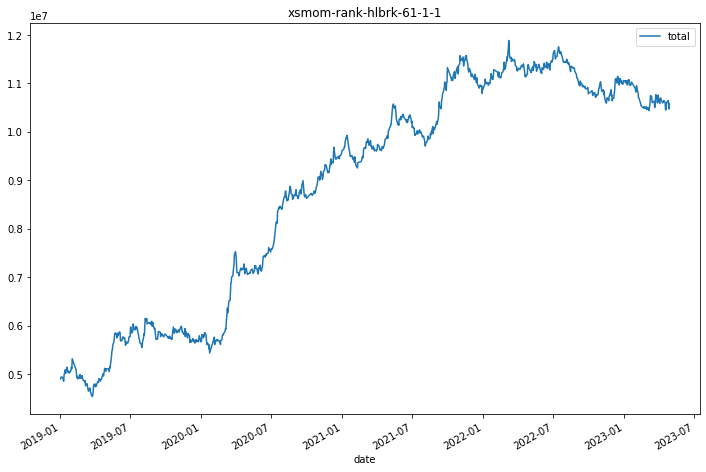

       sharpe       std  sortino
tenor                           
all      1.02  55133.51     1.60
6m      -0.59  68072.78    -1.00
1y      -0.82  62934.20    -1.30
2y       0.29  71516.87     0.50
3y       1.05  69269.33     1.75
4y       1.25  70194.21     2.12
5y       1.10  68218.23     1.84
6y       0.91  66547.19     1.53
7y       0.73  64288.29     1.21
8y       0.81  62322.70     1.33
9y       0.88  60855.47     1.43
10y      0.94  58955.60     1.52
11y      1.03  57045.98     1.64
date
2011-12-30    12820.512821
2012-01-04    12820.512821
2012-01-05    12820.512821
2012-01-06    12820.512821
2012-01-09    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2750, dtype: float64


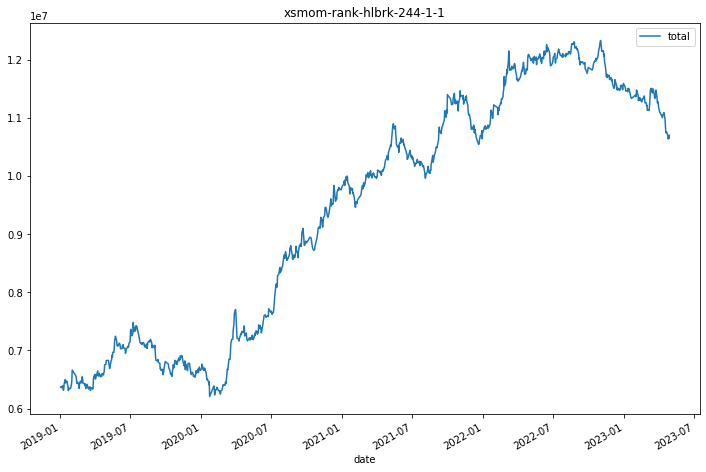

       sharpe       std  sortino
tenor                           
all      1.16  52266.05     1.76
6m      -3.28  56207.60    -5.43
1y      -1.61  54476.87    -2.43
2y       0.17  66183.18     0.28
3y       1.12  65222.28     1.86
4y       0.98  64464.84     1.61
5y       0.97  62761.99     1.57
6y       0.91  60500.57     1.45
7y       0.82  59395.40     1.29
8y       0.84  57997.33     1.33
9y       0.97  56430.10     1.51
10y      1.06  54490.27     1.63
11y      1.14  52809.42     1.73
date
2011-01-31    12820.512821
2011-02-01    12820.512821
2011-02-09    12820.512821
2011-02-10    12820.512821
2011-02-11    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2974, dtype: float64


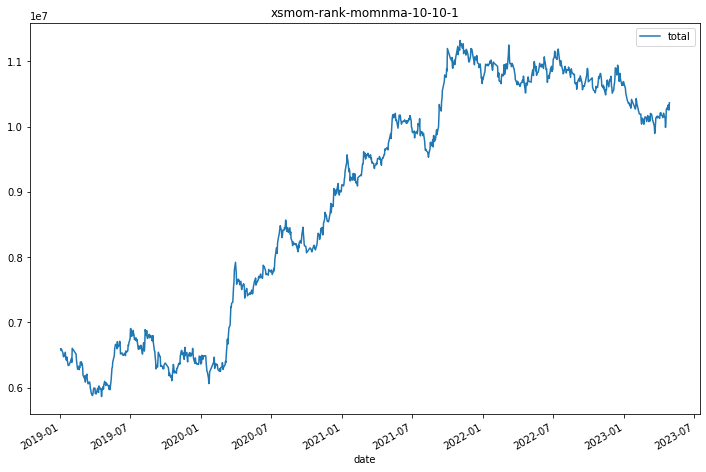

       sharpe       std  sortino
tenor                           
all      1.02  53640.31     1.62
6m      -0.77  65745.70    -1.26
1y      -0.39  64545.64    -0.61
2y       0.31  70611.68     0.51
3y       0.91  67791.65     1.49
4y       1.00  68712.14     1.67
5y       0.79  66469.14     1.33
6y       0.81  64862.90     1.36
7y       0.67  62723.76     1.13
8y       0.79  61216.75     1.33
9y       0.89  59678.81     1.48
10y      1.00  57652.83     1.64
11y      1.05  55784.42     1.69
date
2012-01-11    12820.512821
2012-01-12    12820.512821
2012-01-13    12820.512821
2012-01-16    12820.512821
2012-01-17    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2744, dtype: float64


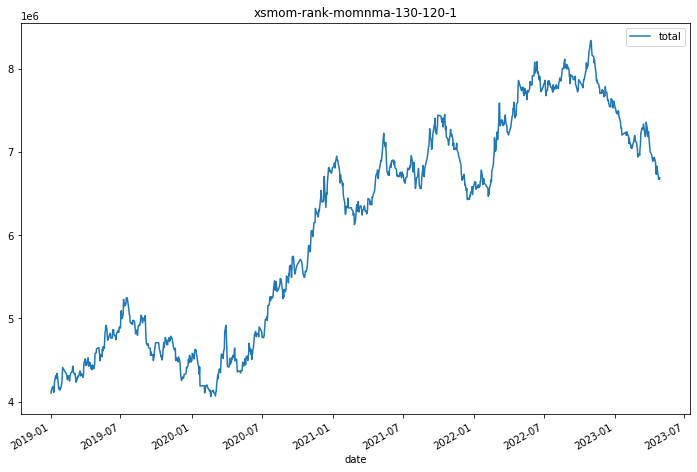

       sharpe       std  sortino
tenor                           
all      0.76  49898.18     1.14
6m      -3.67  52433.76    -5.95
1y      -1.40  53126.02    -2.22
2y      -0.05  62806.78    -0.07
3y       0.74  63155.15     1.18
4y       0.55  61746.80     0.86
5y       0.62  59703.29     0.97
6y       0.60  57850.07     0.93
7y       0.60  56784.92     0.93
8y       0.61  55548.48     0.94
9y       0.65  53775.90     1.01
10y      0.72  51850.76     1.09
11y      0.77  50391.78     1.15
date
2012-03-28    12820.512821
2012-03-29    12820.512821
2012-03-30    12820.512821
2012-04-05    12820.512821
2012-04-06    12820.512821
                  ...     
2023-04-24    12820.512821
2023-04-25    12820.512821
2023-04-26    12820.512821
2023-04-27    12820.512821
2023-04-28    12820.512821
Length: 2694, dtype: float64


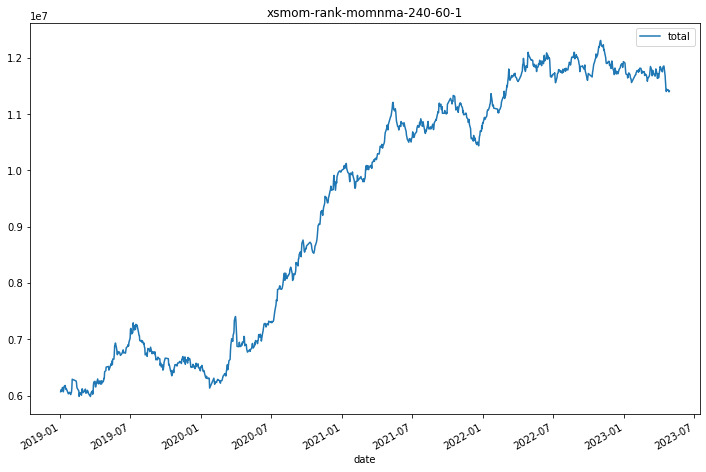

       sharpe       std  sortino
tenor                           
all      1.38  48051.74     2.15
6m      -1.83  54132.61    -2.94
1y      -0.81  54164.19    -1.22
2y       0.34  57606.19     0.54
3y       1.66  57882.09     2.75
4y       1.38  58038.89     2.22
5y       1.27  56410.15     2.06
6y       1.24  55230.97     2.02
7y       1.29  53875.79     2.07
8y       1.23  52869.16     2.00
9y       1.31  51158.84     2.08
10y      1.33  49421.35     2.09
11y      1.37  48142.12     2.15
date
2014-07-01    35714.285714
2014-07-02    35714.285714
2014-07-03    35714.285714
2014-07-04    35714.285714
2014-07-07    35714.285714
                  ...     
2023-04-24    35714.285714
2023-04-25    35714.285714
2023-04-26    35714.285714
2023-04-27    35714.285714
2023-04-28    35714.285714
Length: 2151, dtype: float64


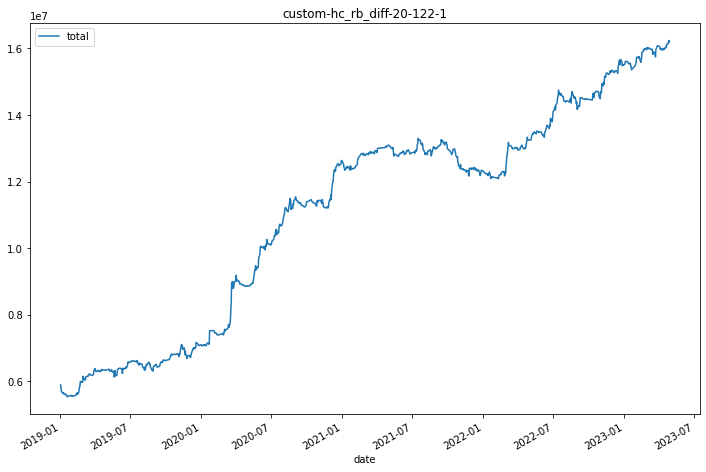

       sharpe       std  sortino
tenor                           
all      1.69  69702.58     2.70
6m       2.70  71933.06     5.55
1y       2.65  70894.74     4.74
2y       1.50  67022.40     2.67
3y       2.30  68172.39     4.07
4y       2.28  69523.34     4.01
5y       2.02  69588.97     3.35
6y       1.72  67877.02     2.81
7y       1.66  70041.09     2.63
8y       1.71  71070.31     2.78
9y       1.69  69702.58     2.70
10y      1.69  69702.58     2.70
11y      1.69  69702.58     2.70
date
2011-01-04    21739.130435
2011-01-05    21739.130435
2011-01-06    21739.130435
2011-01-07    21739.130435
2011-01-10    21739.130435
                  ...     
2023-04-24    21739.130435
2023-04-25    21739.130435
2023-04-26    21739.130435
2023-04-27    21739.130435
2023-04-28    21739.130435
Length: 2993, dtype: float64


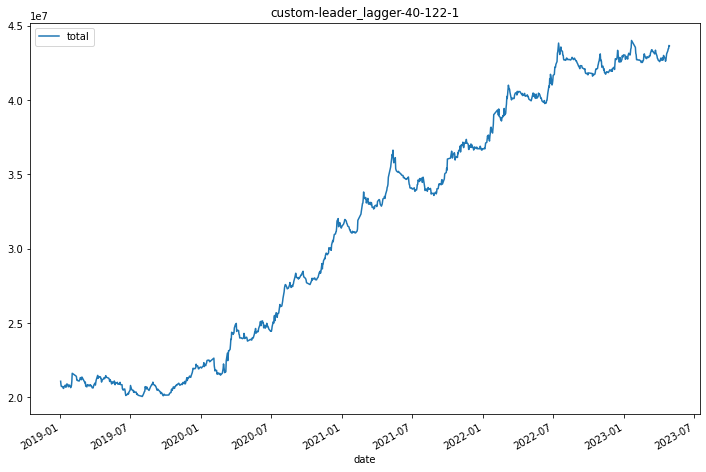

       sharpe        std  sortino
tenor                            
all      1.67  136429.39     2.40
6m       0.77  176513.89     1.11
1y       1.18  182915.75     1.75
2y       1.54  198160.70     2.38
3y       2.21  190133.57     3.45
4y       1.99  181014.83     3.03
5y       1.94  171538.85     2.98
6y       1.80  163499.12     2.75
7y       1.71  158471.89     2.63
8y       1.87  161596.20     2.83
9y       1.79  155186.01     2.68
10y      1.77  149289.31     2.61
11y      1.77  143347.69     2.59


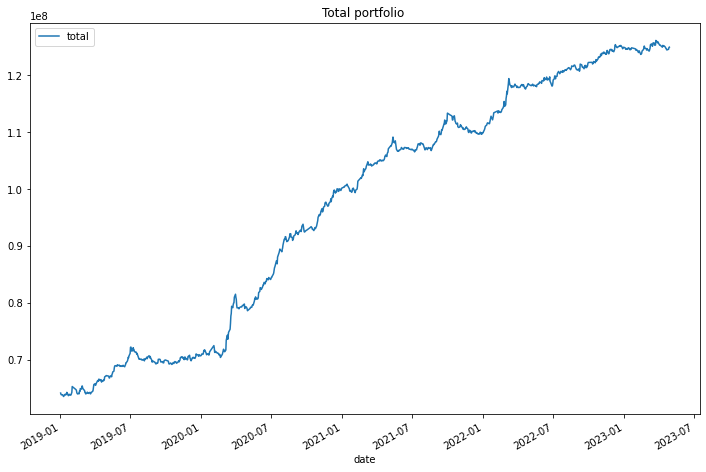

       sharpe        std  sortino
tenor                            
all      2.78  234695.73     4.65
6m       0.94  228757.98     2.03
1y       1.68  243870.27     2.99
2y       2.08  288712.60     3.71
3y       3.27  299148.55     5.87
4y       3.03  306816.23     5.47
5y       2.90  299217.12     5.27
6y       2.73  284993.08     4.84
7y       2.73  281062.64     4.89
8y       2.81  274071.34     5.00
9y       2.83  264123.69     4.96
10y      2.85  255355.31     4.93
11y      2.89  246001.04     4.90
pnl per trade: product
rb     45.391588
hc     76.184554
i     118.274134
j      73.707075
jm     49.947150
ru     27.972046
FG     46.949439
cu     12.251242
al     22.792114
zn     11.016311
sn     40.765046
l      19.960173
pp     39.391890
v      46.935221
TA     62.657237
sc    146.129303
m      19.087591
RM     11.978779
y      45.871854
p      58.897845
OI     38.815363
a       1.794089
c       1.777615
CF     11.053902
jd     21.966163
AP     99.647961
SM     35.415992
eb    21

PermissionError: [Errno 13] Permission denied: 'C:\\dev\\data\\data_cache\\port_pnl.csv'

In [28]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2023,4,28)

scenario_map = {
    'test': scenarios_test,
    'test2': scenarios_test2,
    'elite': scenarios_elite,
}

shift_mode = 2
rev_char = '!'
exec_mode = 'open'
total_risk = 500_000.0
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni', 'SF', 'SA', 'pg', 'CJ', 'PF' ]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'test2'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
        elif signal_name == 'leader_lagger':
            run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'UR', 'sc',
                                        'al', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI', 'SA', 'pg', ]
            run_args['conv_func'] = 'qtl'
            run_args['signal_func'] = leader_lagger    
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


In [11]:
import pickle

port_data = {'empirics': bt_empirics, 'scen_stats': scen_stats, 'scen_names': scen_names, 'holdings': holdings}

out_file = open('port_data_test.pkl','wb')

pickle.dump(port_data, out_file)

out_file.close()

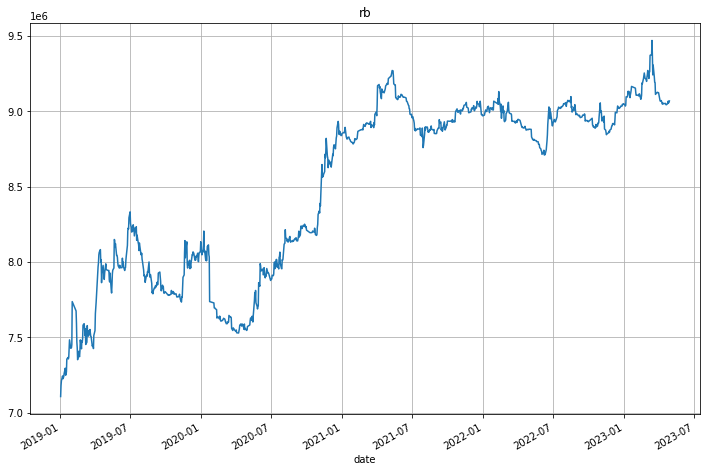

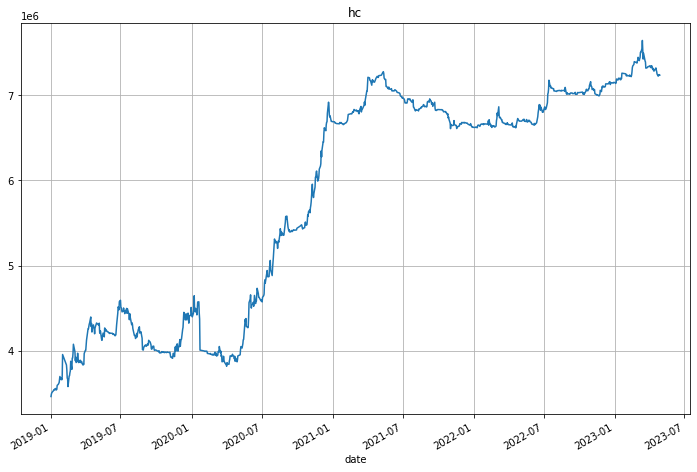

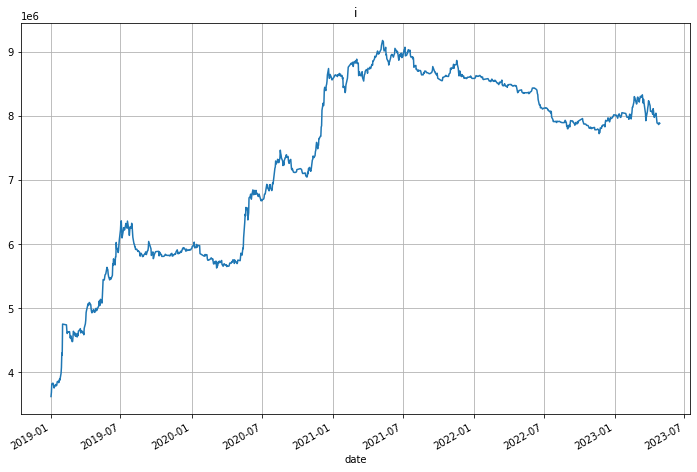

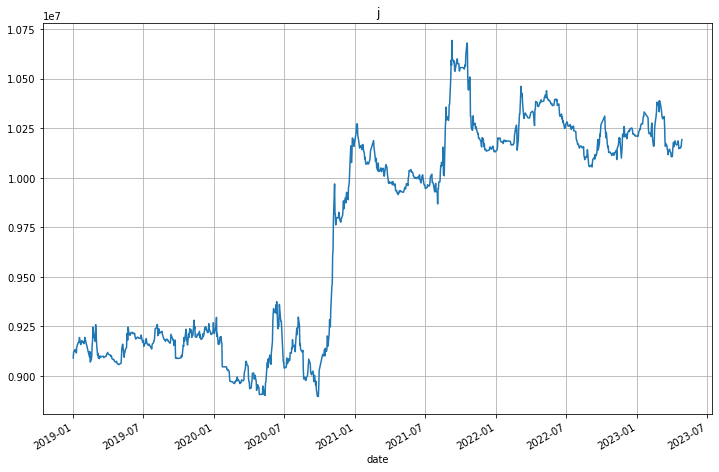

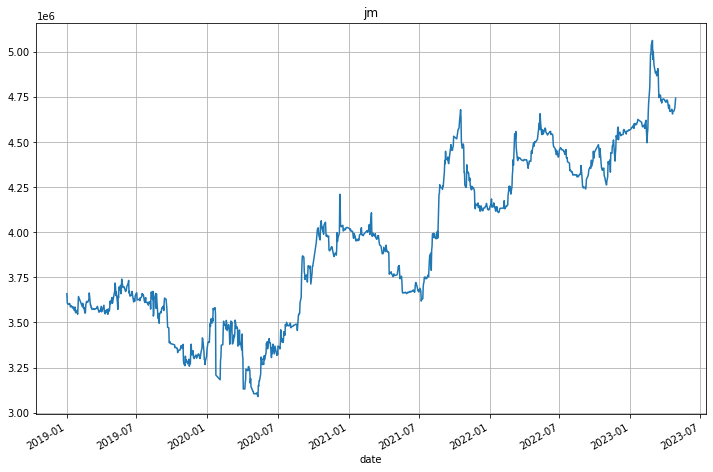

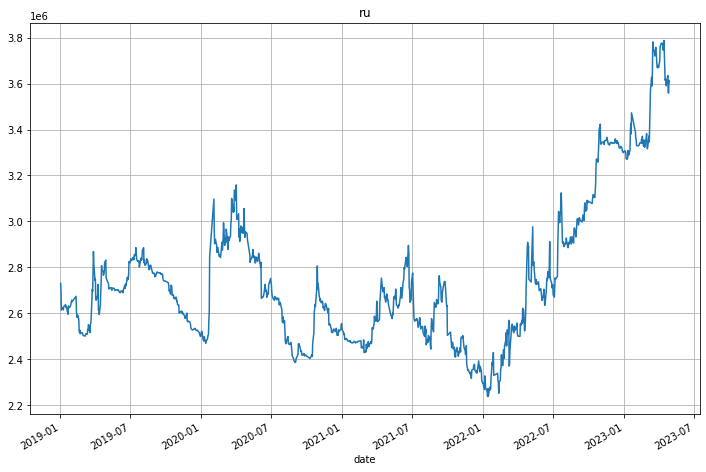

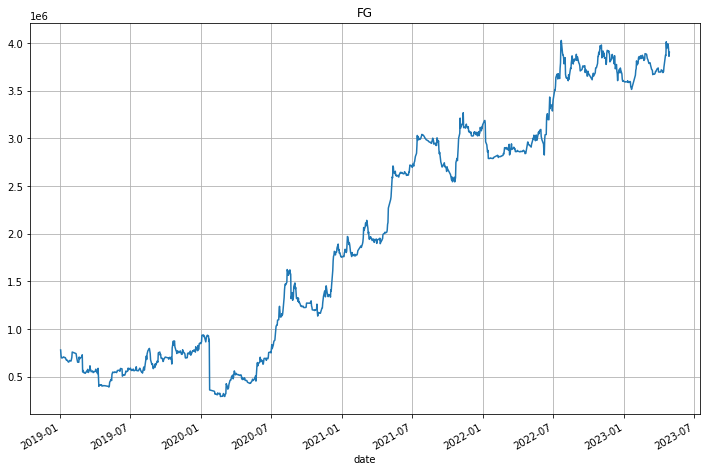

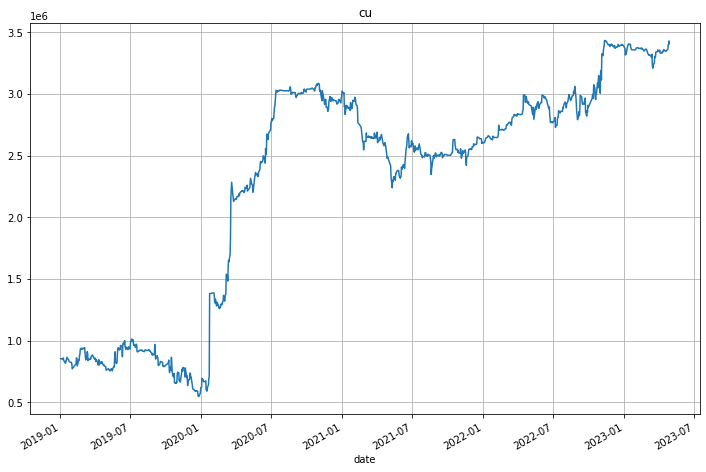

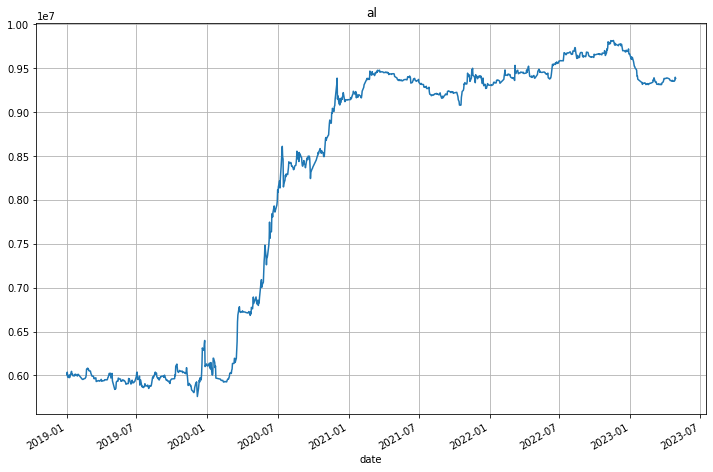

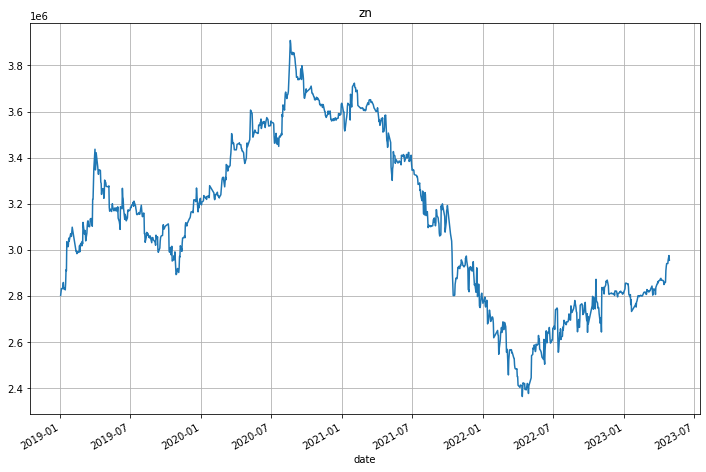

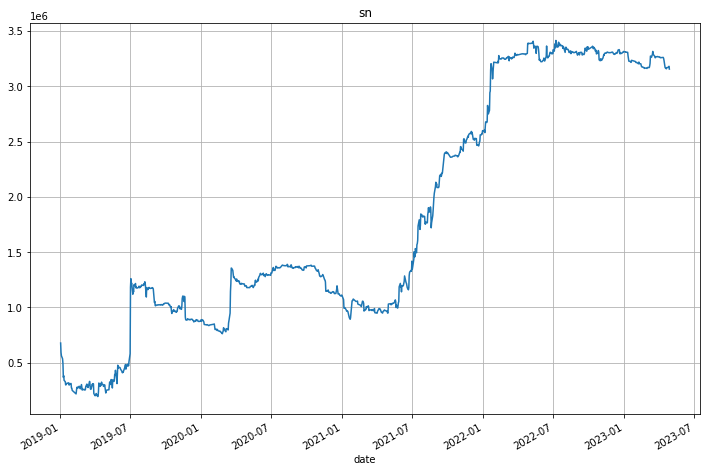

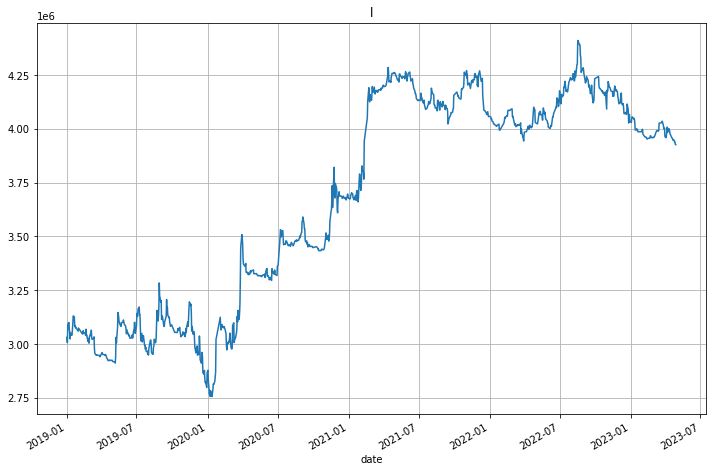

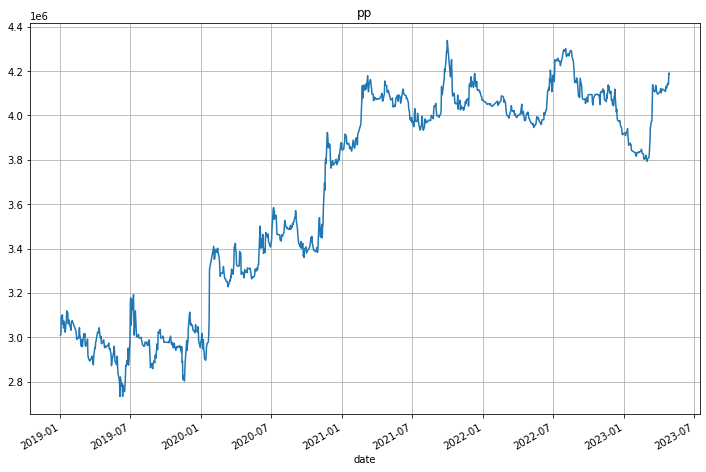

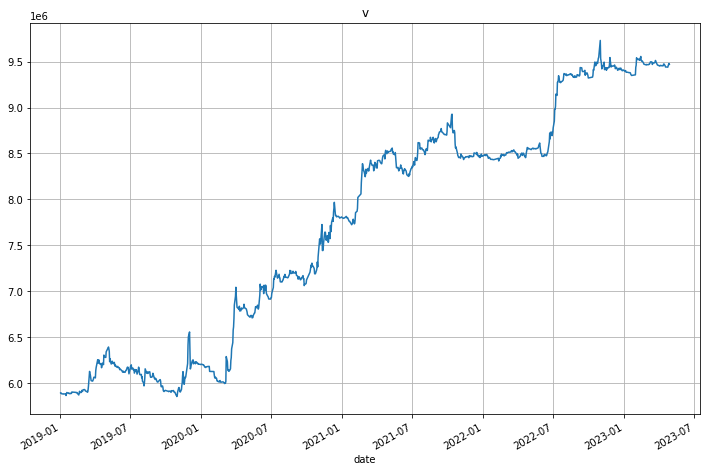

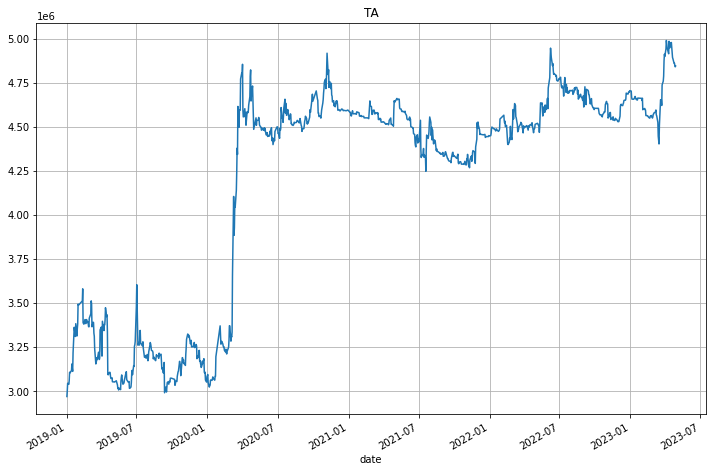

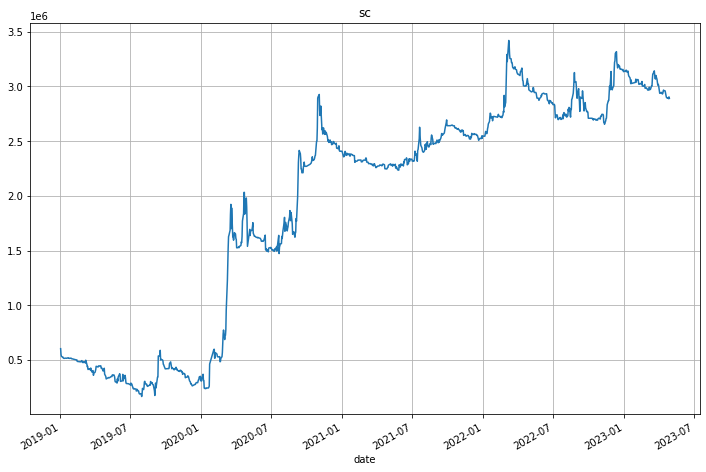

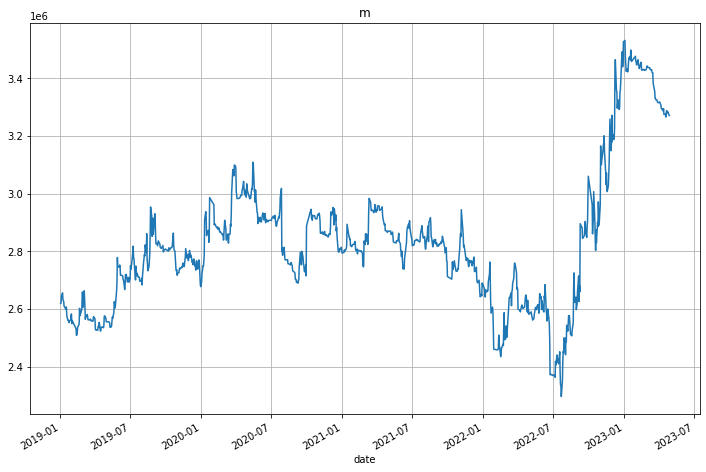

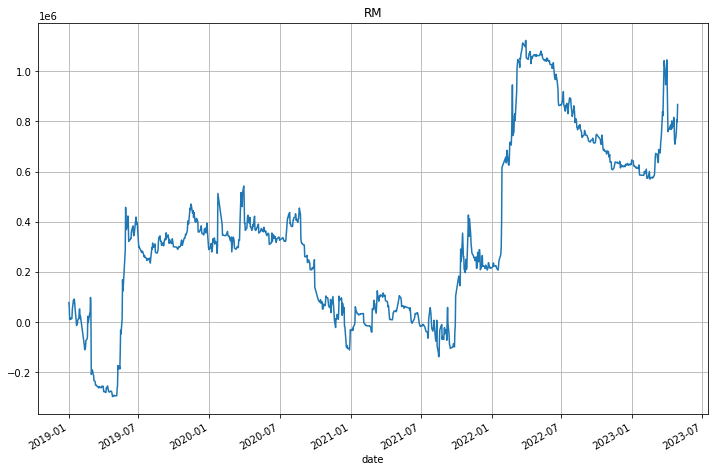

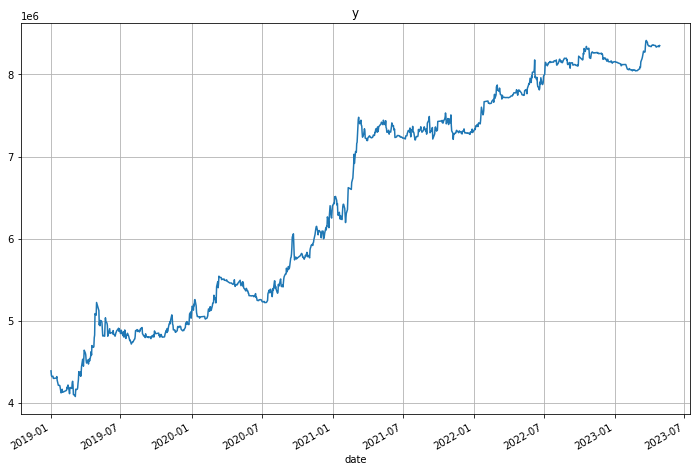

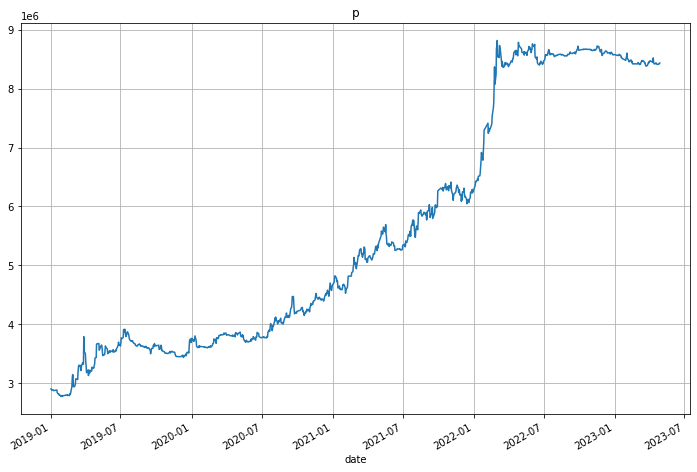

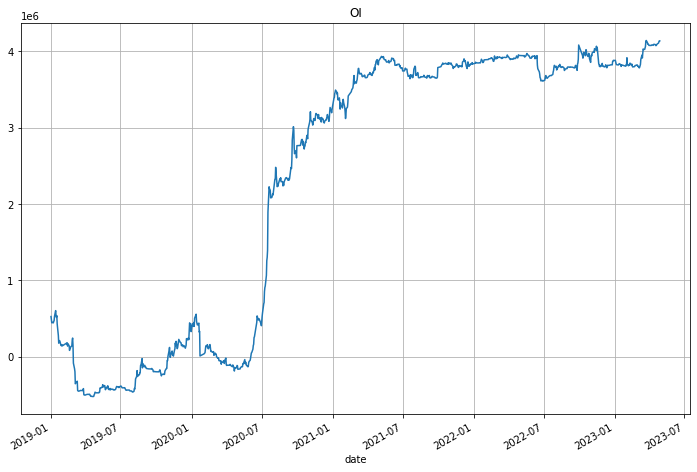

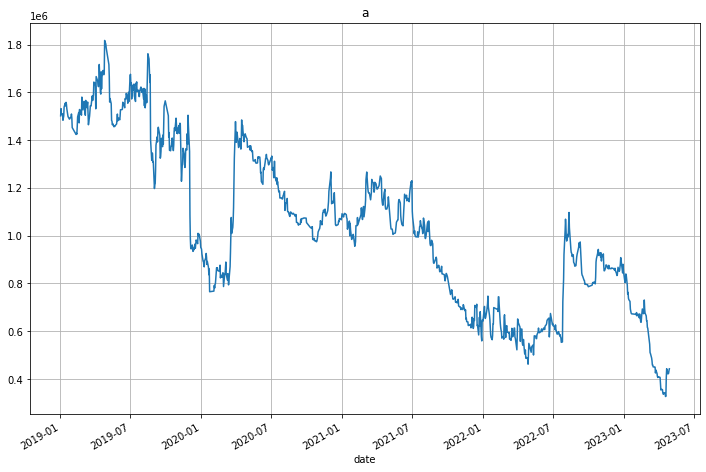

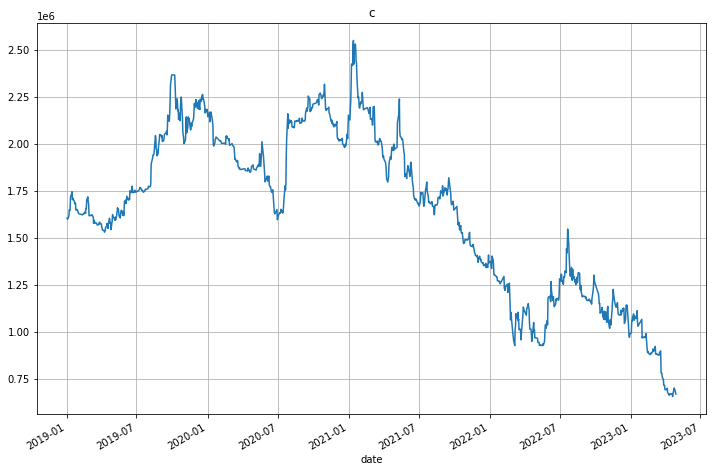

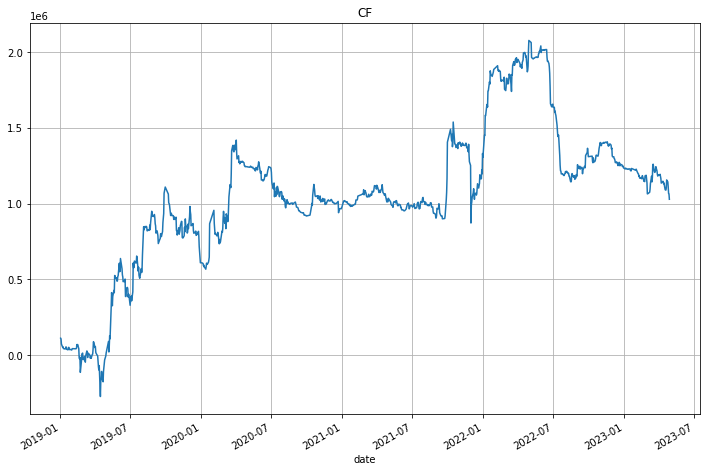

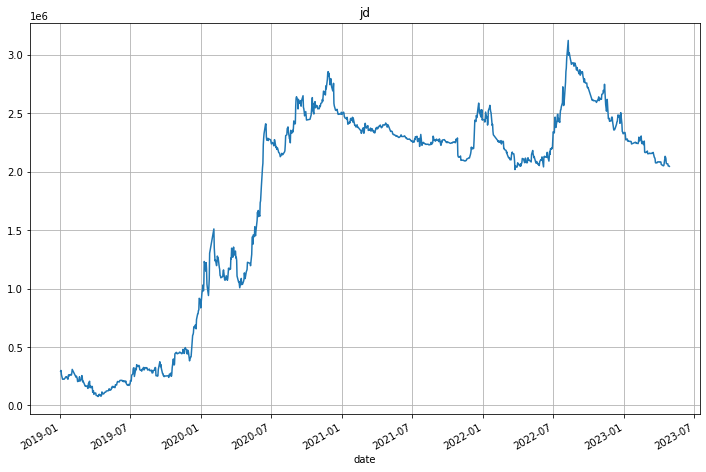

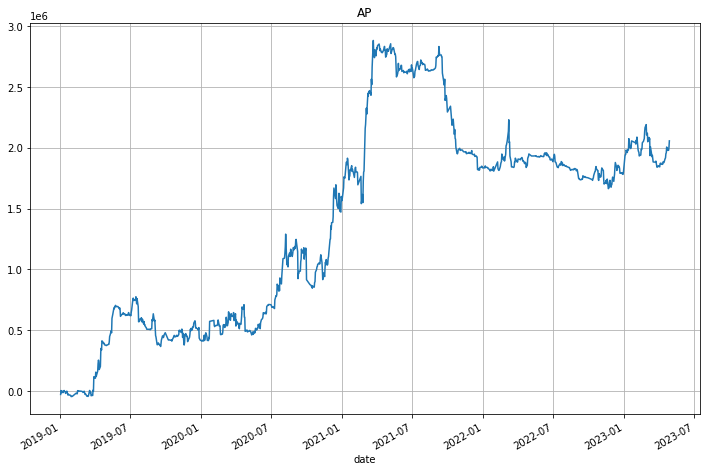

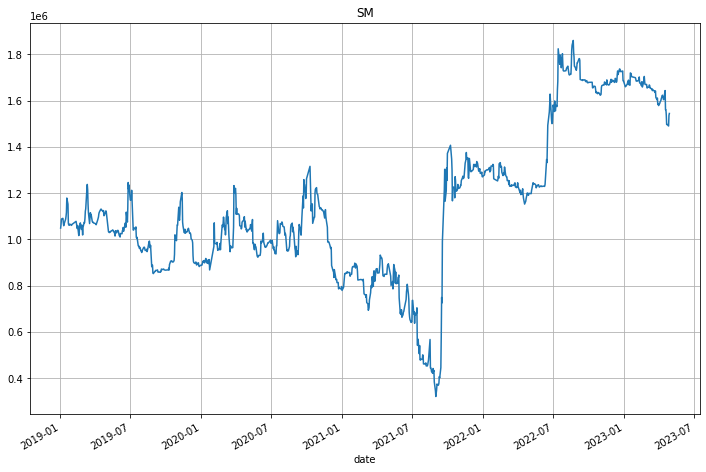

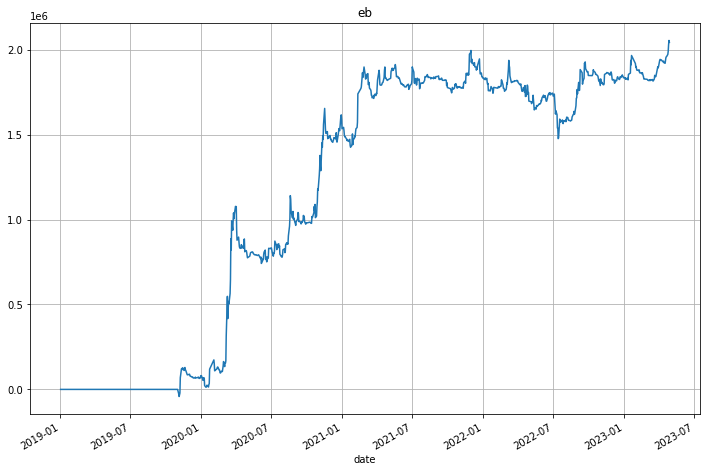

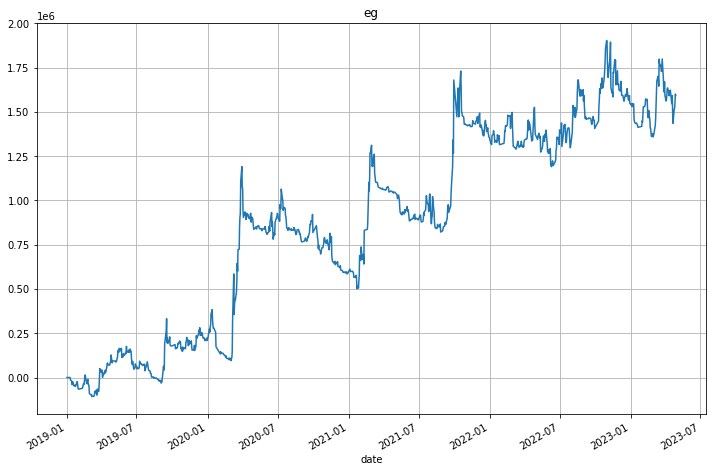

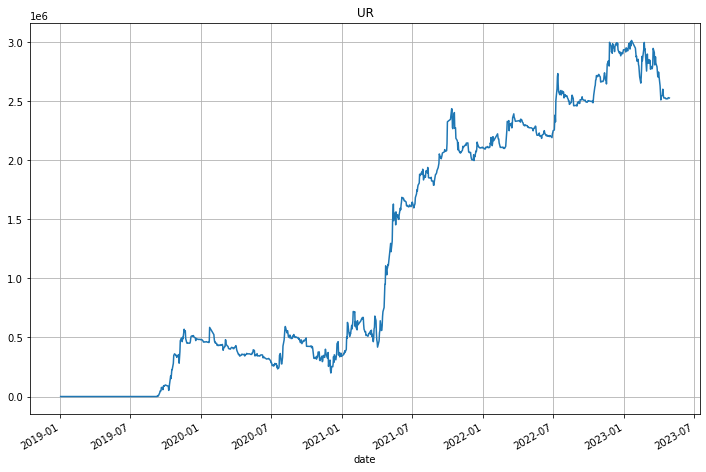

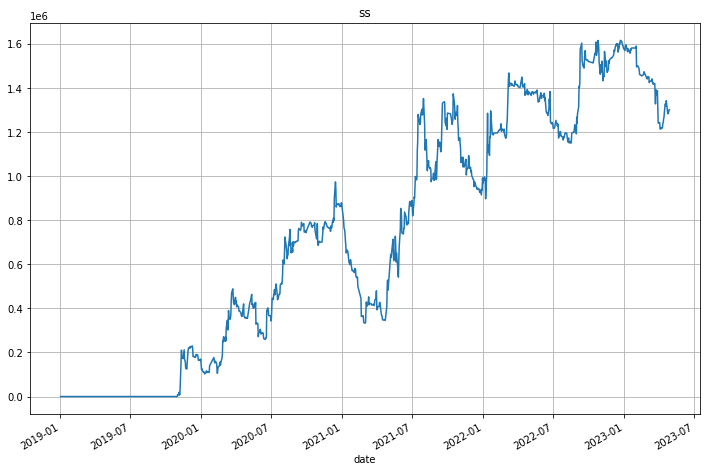

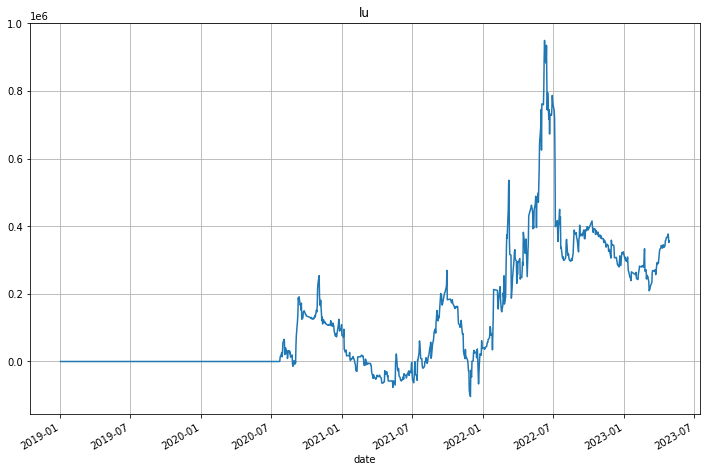

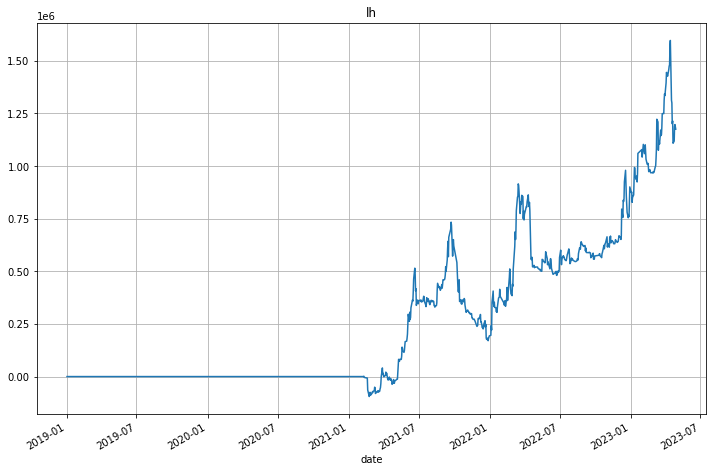

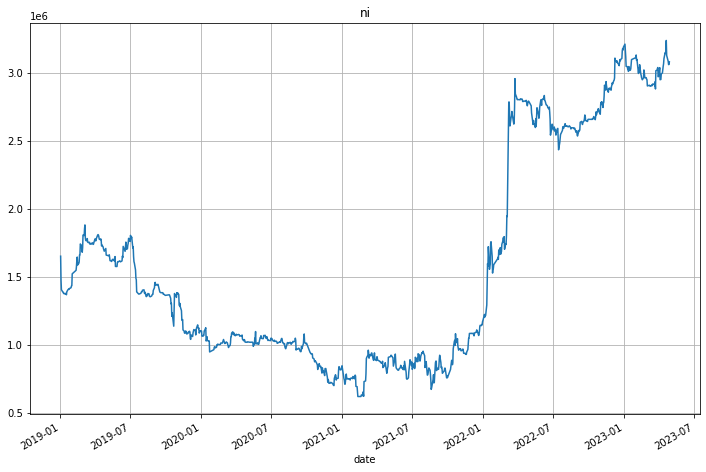

In [27]:
#pnl_stats = bt_empirics[run_key].calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

#pnl_stats['asset_sharpe_stats']

for asset in port_stats['asset_cumpnl'].columns:
    port_stats['asset_cumpnl'][asset]['2019-01-01':].plot(title=asset)
    plt.grid()
    plt.show()

In [20]:
scen_metrics['hot_test2'][-1].holdings[-50:]

product               rb            hc             i             j  \
date                                                                 
2023-02-17  1.864237e+06  1.970653e+06  1.046381e+06  1.673635e+06   
2023-02-20  1.974782e+06  2.070449e+06  1.152938e+06  1.650016e+06   
2023-02-21  2.255075e+06  2.325881e+06  1.669150e+06  1.702688e+06   
2023-02-22  2.234795e+06  2.383891e+06  1.618507e+06  1.748516e+06   
2023-02-23  2.177756e+06  2.316835e+06  1.513752e+06  1.689765e+06   
2023-02-24  2.150439e+06  2.287327e+06  1.492569e+06  1.598480e+06   
2023-02-27  2.112640e+06  2.261010e+06  1.483126e+06  1.553432e+06   
2023-02-28  1.808847e+06  1.951959e+06  1.182671e+06  1.336903e+06   
2023-03-01  1.644959e+06  1.856350e+06  1.037897e+06  1.220260e+06   
2023-03-02  2.229757e+06  2.608105e+06  1.293144e+06  1.594181e+06   
2023-03-03  2.439814e+06  2.879175e+06  1.518870e+06  1.713749e+06   
2023-03-06  2.542431e+06  2.990920e+06  1.638631e+06  1.827095e+06   
2023-03-07  1.968505e+06  2.323197e+06  1.258128e+06  1.461473e+06   
2023-03-08  2.246412e+06  2.696849e+06  1.450168e+06  1.634187e+06   
2023-03-09  2.219362e+06  2.757546e+06  1.421924e+06  1.621856e+06   
2023-03-10  2.336891e+06  2.889985e+06  1.586207e+06  1.764140e+06   
2023-03-13  2.302473e+06  2.872663e+06  1.536446e+06  1.892690e+06   
2023-03-14  2.697641e+06  3.217437e+06  1.683251e+06  2.056308e+06   
2023-03-15  2.699377e+06  3.313036e+06  1.679645e+06  1.766279e+06   
2023-03-16  2.370210e+06  2.946438e+06  1.547867e+06  1.554444e+06   
2023-03-17  1.048903e+06  1.160122e+06  7.542047e+05  8.332483e+05   
2023-03-20  1.585196e+06  1.759739e+06  1.164046e+06  1.366096e+06   
2023-03-21  6.761734e+05  7.609025e+05  4.630252e+05  6.110694e+05   
2023-03-22  8.221435e+04  8.953760e+04  5.840722e+04  7.300831e+04   
2023-03-23  1.742588e+05  1.903418e+05  1.222503e+05  1.539206e+05   
2023-03-24 -6.658247e+05 -7.382383e+05 -4.934240e+05 -6.635036e+05   
2023-03-27 -2.851582e+05 -3.185794e+05 -2.098000e+05 -2.771556e+05   
2023-03-28 -4.396616e+05 -4.852304e+05 -3.381934e+05 -4.234819e+05   
2023-03-29 -1.833732e+05 -2.026081e+05 -1.411487e+05 -1.703741e+05   
2023-03-30 -1.284946e+04 -1.424890e+04 -1.017990e+04 -1.305985e+04   
2023-03-31  1.931779e+05  2.154296e+05  1.488570e+05  1.943735e+05   
2023-04-03  4.315030e+05  4.838737e+05  3.263640e+05  3.781840e+05   
2023-04-04 -1.032863e+06 -1.140323e+06 -8.791852e+05 -8.339839e+05   
2023-04-06 -1.492699e+06 -1.614067e+06 -1.279537e+06 -1.176134e+06   
2023-04-07 -1.623374e+06 -1.751687e+06 -1.398501e+06 -1.272626e+06   
2023-04-10 -1.212605e+06 -1.292479e+06 -1.035315e+06 -9.315936e+05   
2023-04-11 -1.650745e+06 -1.773457e+06 -1.401314e+06 -1.305611e+06   
2023-04-12 -1.488263e+06 -1.622052e+06 -1.187788e+06 -1.158896e+06   
2023-04-13 -1.702224e+06 -1.860906e+06 -1.348702e+06 -1.366370e+06   
2023-04-14 -1.748358e+06 -1.897445e+06 -1.340777e+06 -1.391521e+06   
2023-04-17 -1.836550e+06 -1.992394e+06 -1.337073e+06 -1.321954e+06   
2023-04-18 -1.516970e+06 -1.632654e+06 -1.089309e+06 -1.069168e+06   
2023-04-19 -1.315806e+06 -1.399714e+06 -1.030076e+06 -8.839293e+05   
2023-04-20 -1.629953e+06 -1.723994e+06 -1.260615e+06 -1.090955e+06   
2023-04-21 -1.825846e+06 -1.925261e+06 -1.381265e+06 -1.163898e+06   
2023-04-24 -1.938041e+06 -2.046426e+06 -1.341415e+06 -1.292152e+06   
2023-04-25 -1.834764e+06 -1.874603e+06 -1.371964e+06 -1.346344e+06   
2023-04-26 -1.837042e+06 -1.875374e+06 -1.379927e+06 -1.346473e+06   
2023-04-27 -1.705278e+06 -1.768099e+06 -1.297505e+06 -1.287214e+06   
2023-04-28 -1.804910e+06 -1.874905e+06 -1.388791e+06 -1.351392e+06   

product               jm            SM            FG             v  \
date                                                                 
2023-02-17  1.497435e+06  1.804887e+06  9.142267e+05  1.476371e+06   
2023-02-20  1.574781e+06  1.831324e+06  9.790629e+05  1.598328e+06   
2023-02-21  1.633201e+06  1.946834e+06  1.100372e+06  1.766201e+06   
2023-02-2

In [16]:
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)


In [13]:
ts1 = bt_empirics['hot_elite'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']
ts2 = bt_empirics['hot_test'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']


# holding and std for strategy group

In [13]:
file_folder = "C:\\dev\\data\\data_cache\\"

#port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl_est.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product             rb          hc            i           j           jm  \
date                                                                       
2011-01-05    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-06    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-07    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-10    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-11    0.000000    0.000000     0.000000    0.000000     0.000000   
...                ...         ...          ...         ...          ...   
2023-02-24  604.808482  735.324362  2549.031610  724.911486  1243.721959   
2023-02-27  806.274123  848.178152  2688.410716  760.985279  1056.453553   
2023-02-28  643.979541  630.660872  2977.451883  825.346491  1280.977788   
2023-03-01  675.590222  849.247004  3181.068205  760.230648  1016.117231   
2023-03-02  702.130979  828.766438  3425.999538  870.561510  1075.949249   

product    

In [21]:
tenors = ['1y', '2y', '3y', '5y', '7y', '9y', '11y']
data_list = []
run_key = 'hot_test'
for scen_name, scen, pl_stat in zip(scen_names[run_key], scenarios, scen_stats[run_key]):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

weight         std_1y         std_2y  \
strat_name                                                               
tscarry-ryieldnmb-1-122-1         0.1550  223213.759725  218546.874822   
tscarry-ryieldqtl-1-20-1          0.1800   91045.850128   85978.884705   
tscarry-ryieldqtl-1-60-1          0.1800   90969.318689   87437.589798   
tscarry-ryieldqtl-1-244-1         0.1800   94569.565848   86230.733759   
tscarry-basmomnma-20-122-1        0.0945  163693.000624  150290.582109   
tscarry-basmomnma-60-122-1        0.0758  204625.710727  186650.088834   
tscarry-basmomnma-120-122-1       0.0595  231860.920791  232201.826537   
tscarry-basmomnma-180-122-1       0.0484  292827.067295  295875.890381   
tscarry-basmomqtl-120-20-1        0.1510   95653.930278   86342.223573   
tscarry-basmomqtl-240-20-1        0.0844   94151.629389   86285.237142   
xscarry-rank-ryieldnma-1-20-1     0.0000   56103.992141   57006.658691   
xscarry-rank-ryieldnma-1-122-1    1.2200   55642.963363   58554.548993   
xscarry-rank-ryieldnma-1-244-1    0.0000   56072.654136   58545.049736   
xscarry-rank-basmomnma-20-122-1   0.5020   52823.031558   52473.257602   
xscarry-rank-basmomnma-100-122-1  0.4200   52235.435631   51314.403092   
xscarry-rank-basmomnma-170-122-1  0.5270   48248.494316   48377.433429   
tsmom-hlbrk-20-1-10               0.1630   55694.944895   55318.543070   
tsmom-hlbrk-40-1-10               0.0000   55298.934561   58908.814247   
tsmom-hlbrk-61-1-10               0.1470   55515.881853   58737.914028   
tsmom-hlbrk-122-1-10              0.0000   54719.835317   56569.139795   
tsmom-hlbrk-244-1-10              0.1430   47257.257935   58741.818812   
tsmom-macdnma-8-160-5             0.0406  217682.500758  220397.368770   
tsmom-macdnma-16-160-5            0.0381  210518.627664  228349.935969   
tsmom-macdnma-24-160-5            0.0369  207490.611391  228780.772069   
xsmom-rank-hlbrk-20-1-1           0.1190   67788.667594   72890.664896   
xsmom-rank-hlbrk-40-1-1           0.0000   66789.903930   74396.300118   
xsmom-rank-hlbrk-61-1-1           0.1170   64767.604114   73387.052868   
xsmom-rank-hlbrk-122-1-1          0.0000   62791.263757   71226.641759   
xsmom-rank-hlbrk-244-1-1          0.1220   58491.111676   69490.283963   
xsmom-rank-momnma-10-10-1         0.1200   66588.070363   72098.991263   
xsmom-rank-momnma-130-120-1       0.1250   58485.853031   65288.969385   
xsmom-rank-momnma-240-60-1        0.1370   59044.325869   59943.902461   
custom-hc_rb_diff-20-122-1        1.4560   70905.607370   66965.977941   
custom-leader_lagger-40-122-1     0.4000  151864.965511  167088.367945   

                                         std_3y         std_5y         std_7y  \
strat_name                                                                      
tscarry-ryieldnmb-1-122-1         194278.358413  180389.325255  162795.464701   
tscarry-ryieldqtl-1-20-1           82736.748730   84475.355961   80753.281976   
tscarry-ryieldqtl-1-60-1           83112.219277   90836.316912   85282.501595   
tscarry-ryieldqtl-1-244-1          81689.260261   91201.613967   83863.818004   
tscarry-basmomnma-20-122-1        144901.002930  150363.022909  145079.963889   
tscarry-basmomnma-60-122-1        178544.262980  188350.190676  177235.682437   
tscarry-basmomnma-120-122-1       226248.522670  232008.237733  225604.102528   
tscarry-basmomnma-180-122-1       283152.089617  303950.467072  310621.839988   
tscarry-basmomqtl-120-20-1         82615.074449   85304.493381   81605.854240   
tscarry-basmomqtl-240-20-1         83827.615817   84363.322268   80130.248364   
xscarry-rank-ryieldnma-1-20-1      61600.500299   63094.059923   60869.014336   
xscarry-rank-ryieldnma-1-122-1     61395.659817   62171.128395   60151.219773   
xscarry-rank-ryieldnma-1-244-1     60327.470598   61322.752550   59220.805725   
xscarry-rank-basmomnma-20-122-1    52611.188058   53507.367326   52529.829852   
xscarry-rank-basmomnma-100-122-1   53592.437956   55546.078190   53446.25

In [22]:
data_df.to_excel("port_perf_check.xlsx")

# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.323876  0.809957  0.724711  0.475860  0.428585  0.562446   
sharpe_6m  -0.890350  0.134250  1.753153       NaN       NaN -0.504611   
sharpe_1y  -0.267060  1.519788  0.586632 -1.891429       NaN  0.957608   
sharpe_2y  -0.190253  1.125374  0.300596  0.216499  0.535823  0.590105   
sharpe_3y   0.494870  1.888858  1.184239 -0.237671  0.420748  0.337683   
sharpe_4y   0.449147  1.456568  0.949912  0.112318  0.035228  0.506445   
sharpe_5y   0.199359  1.256697  0.883913  0.001861  0.174178  0.603708   
sharpe_6y   0.094969  1.078674  0.749858  0.471455  0.037831  0.671506   
sharpe_7y   0.088793  0.990913  0.828085  0.557333  0.526836  0.562704   
sharpe_8y   0.314868  0.856111  0.783751  0.652089  0.409960  0.513486   
sharpe_9y   0.331092  0.809957  0.738972  0.578575  0.449763  0.534781   
sharpe_10y  0.311325  0.809957  0.724711  0.650699  0.428585  0.591412   
sharpe_11y  0.323876  0.809957  0.7247

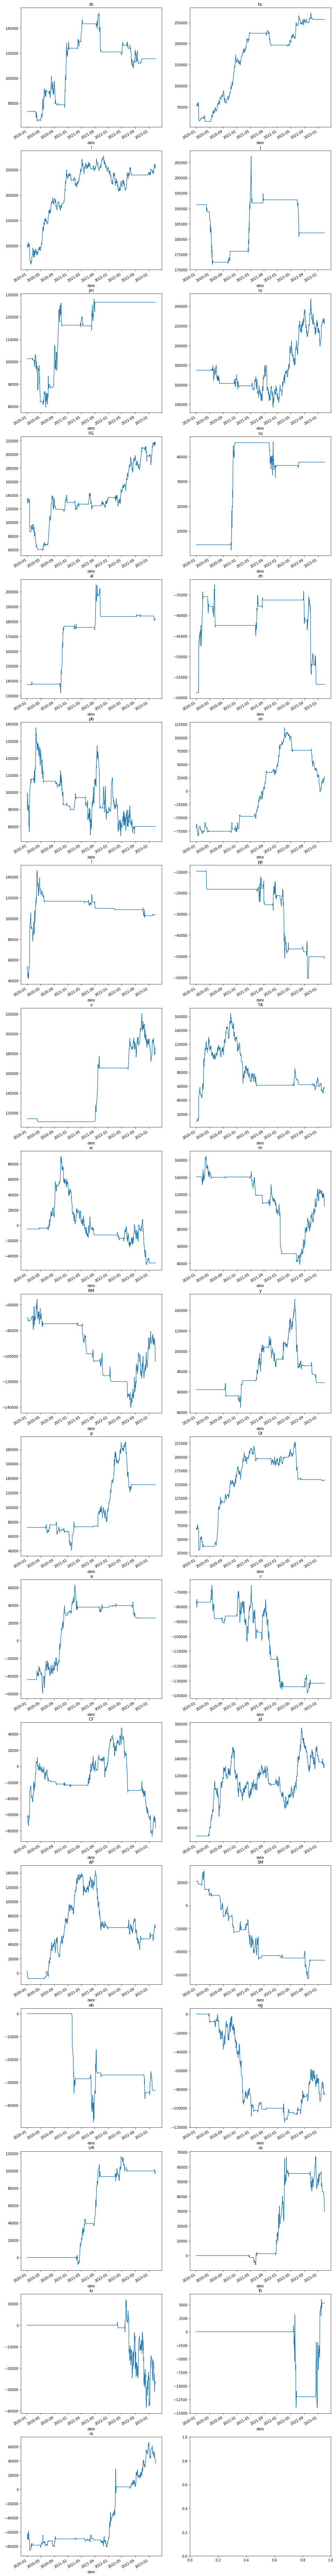

In [15]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2020-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


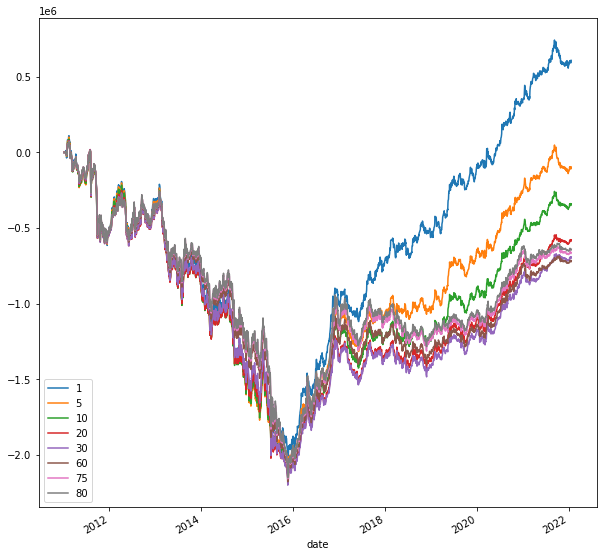

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


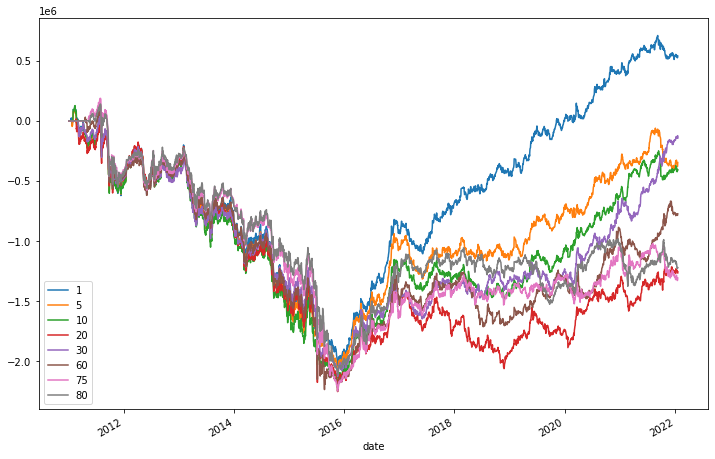

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

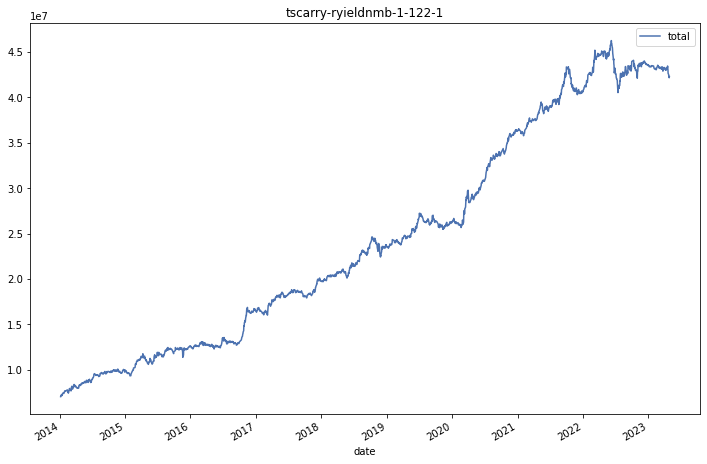

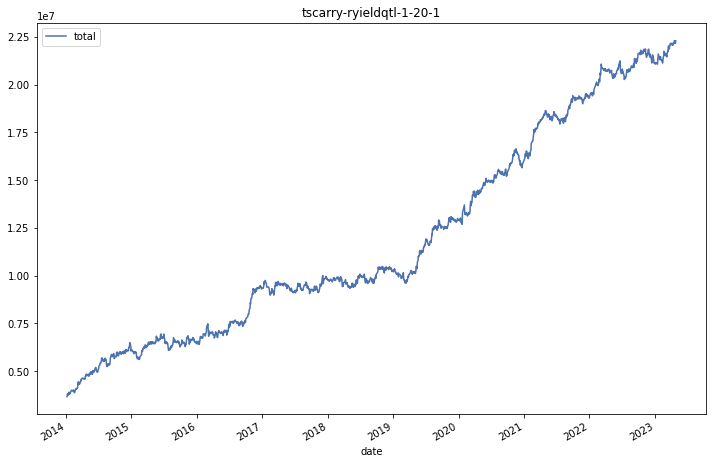

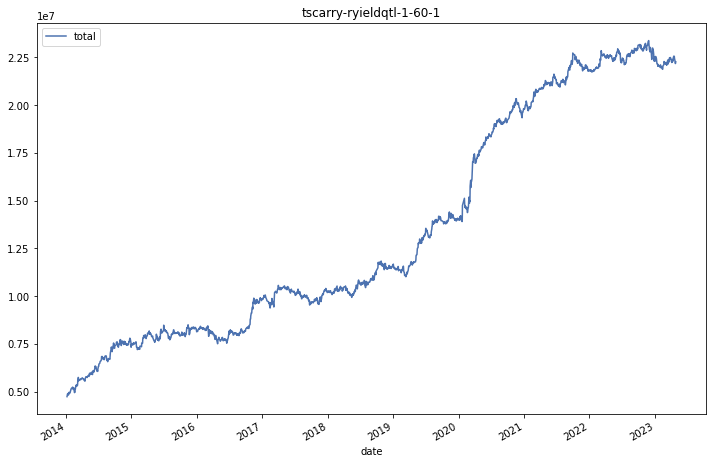

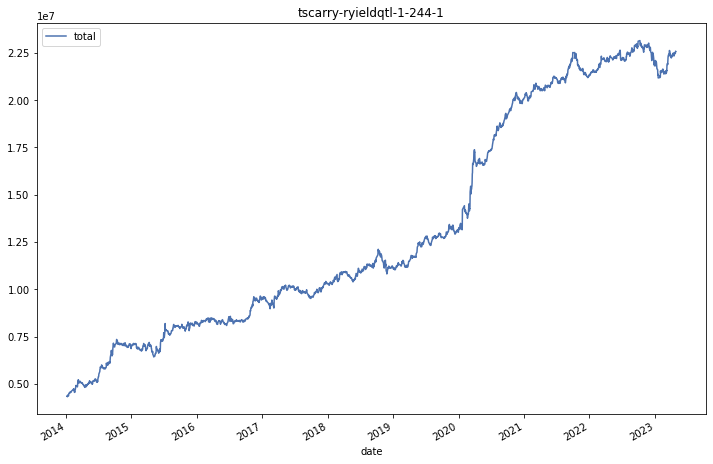

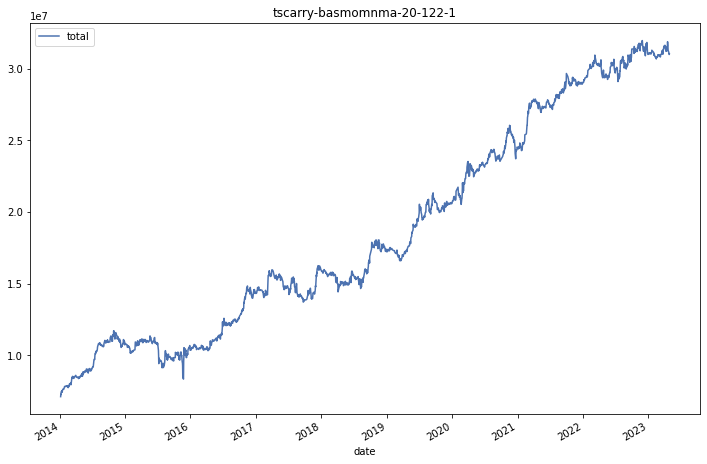

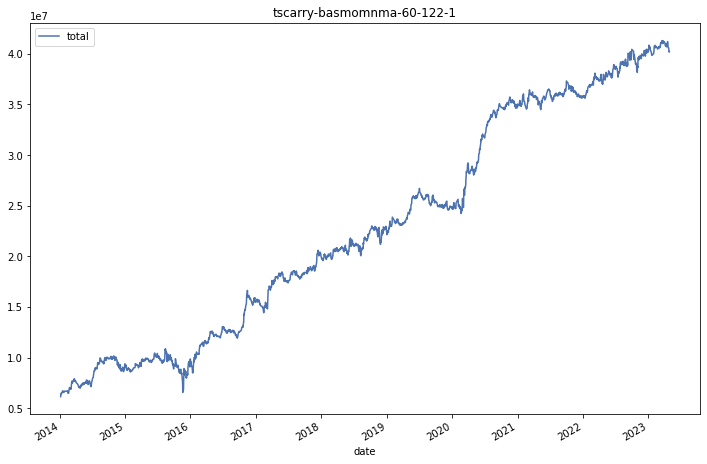

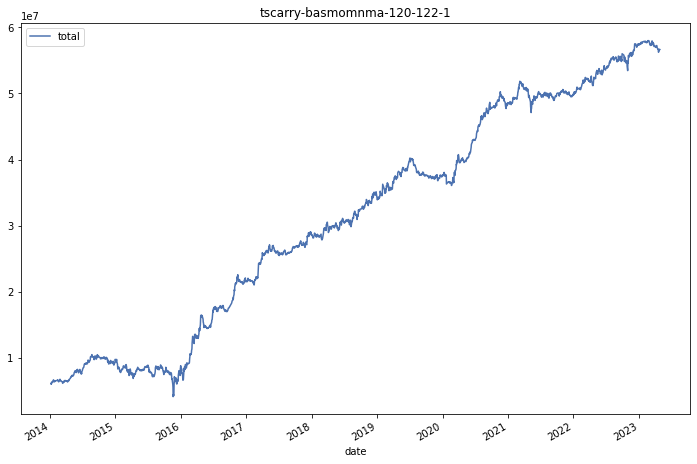

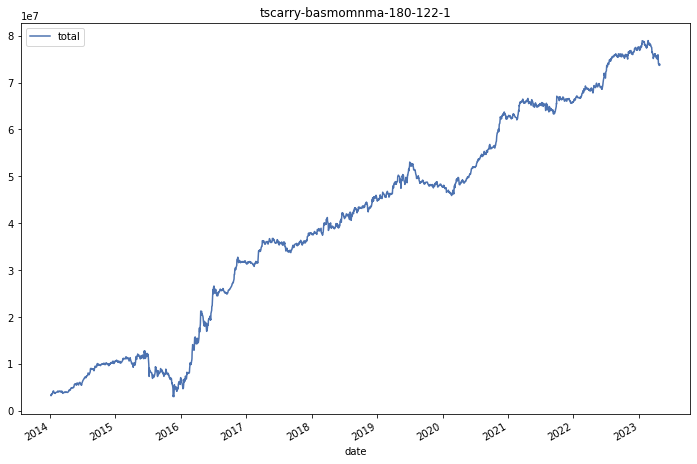

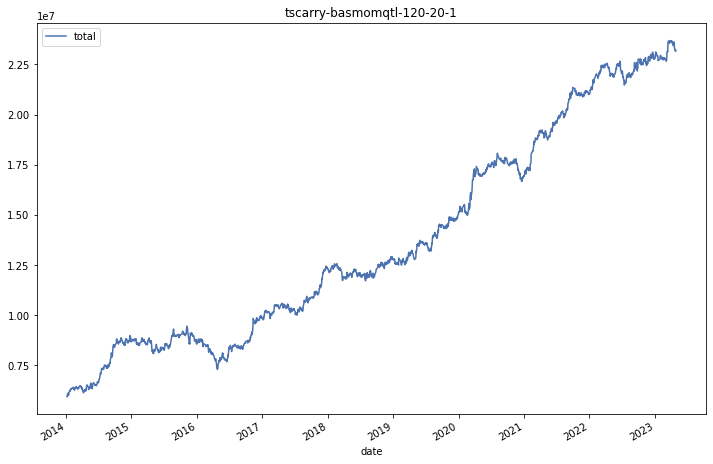

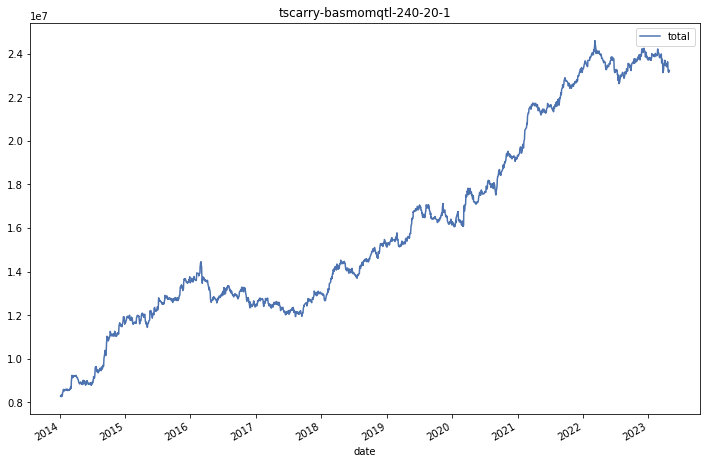

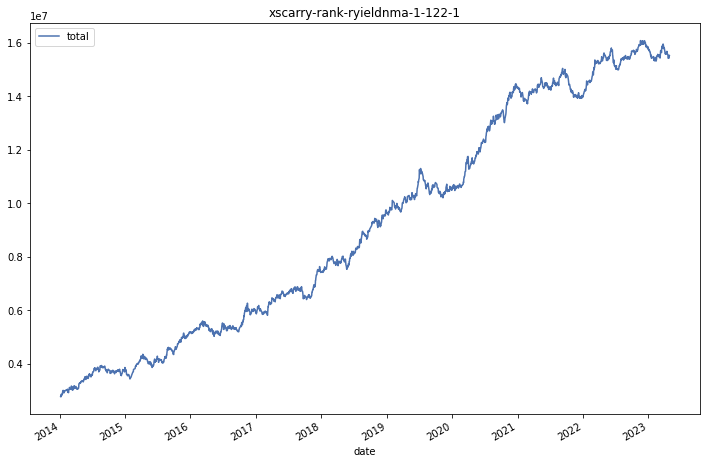

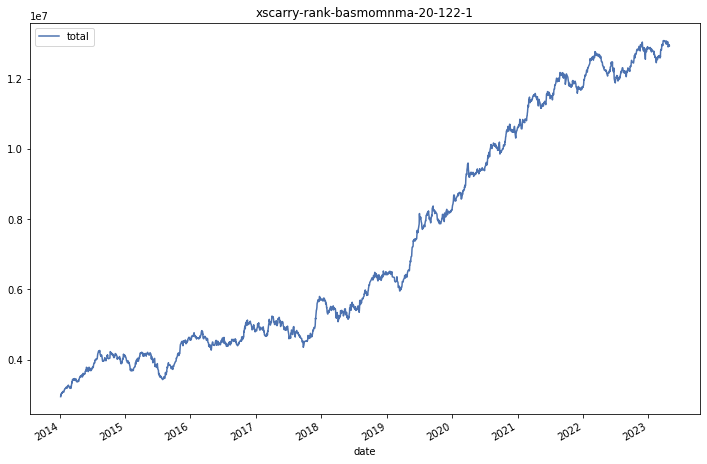

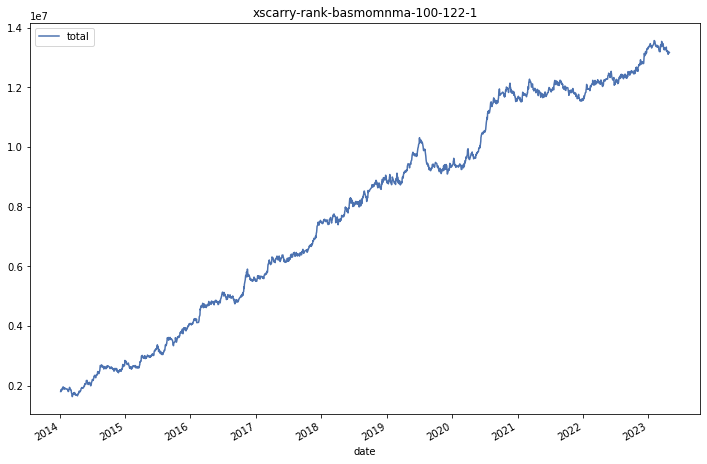

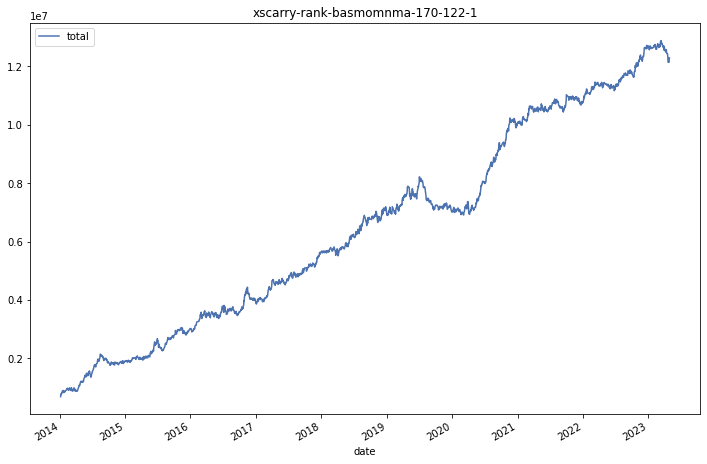

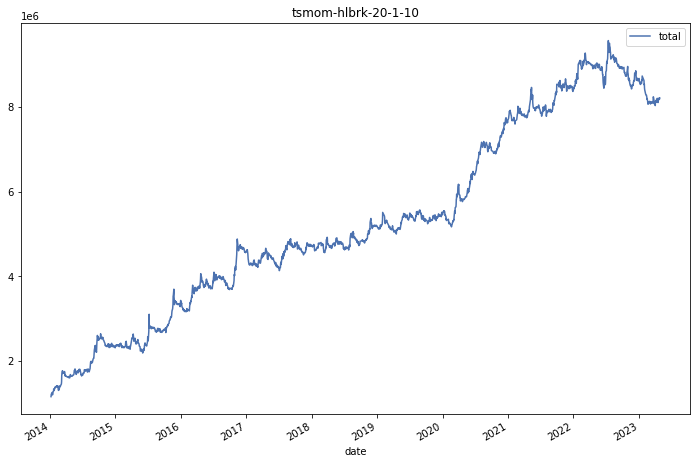

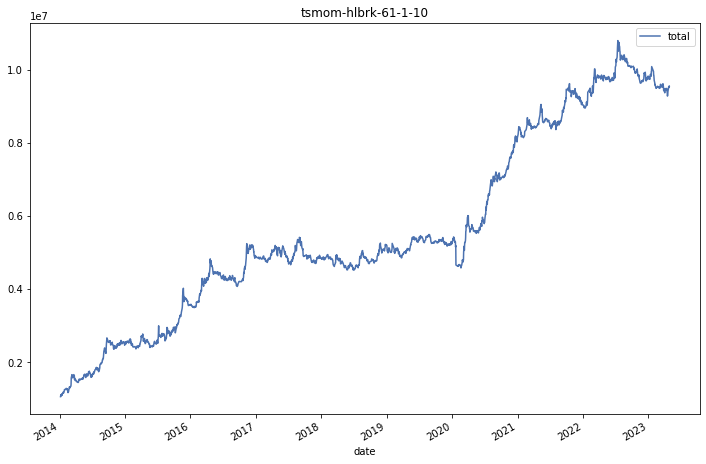

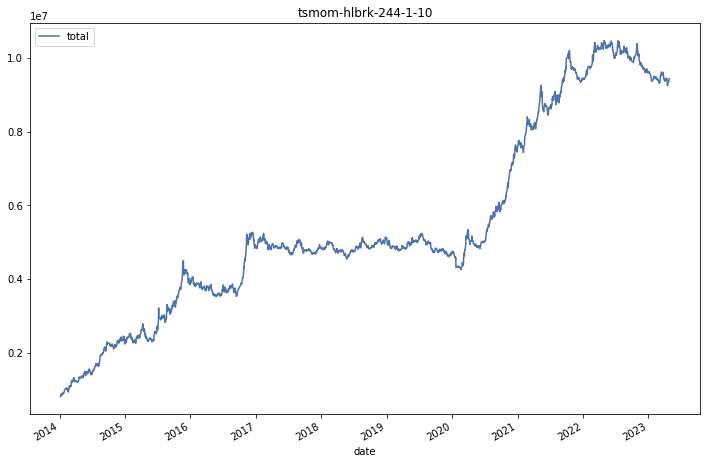

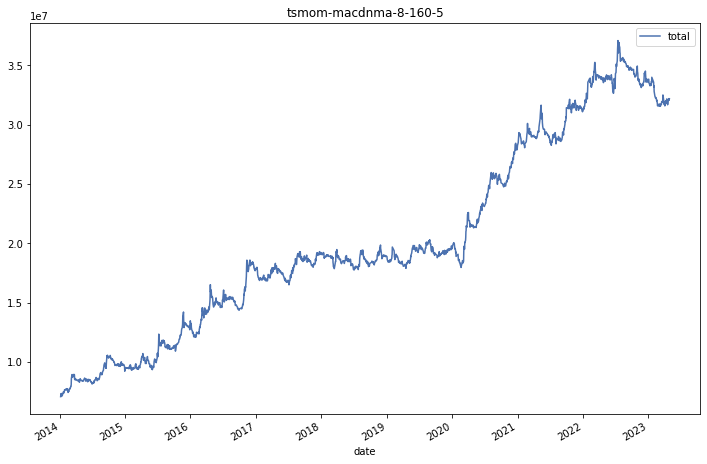

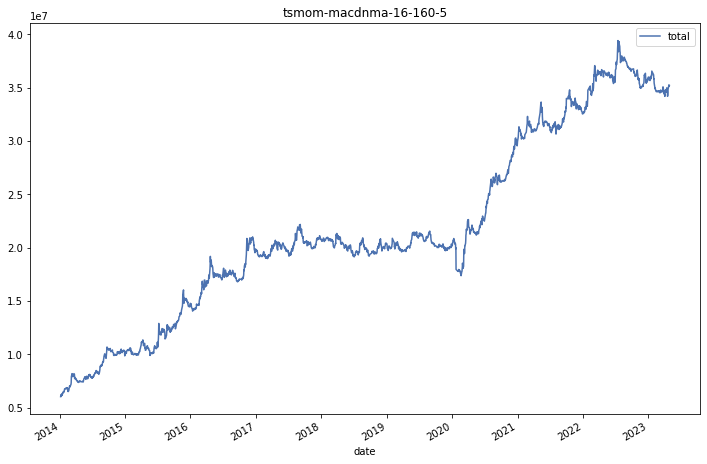

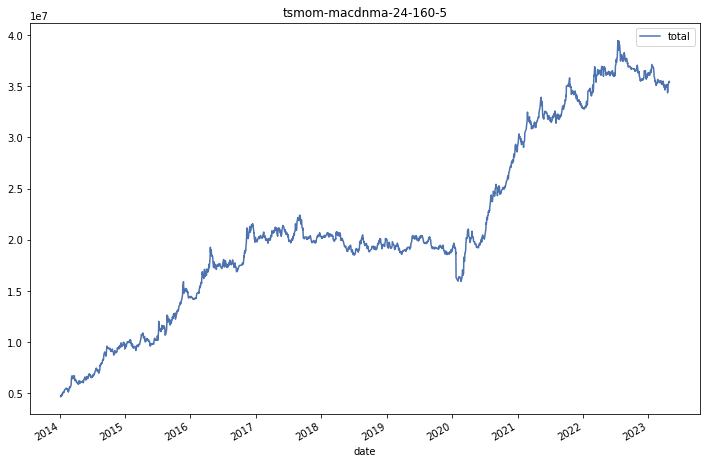

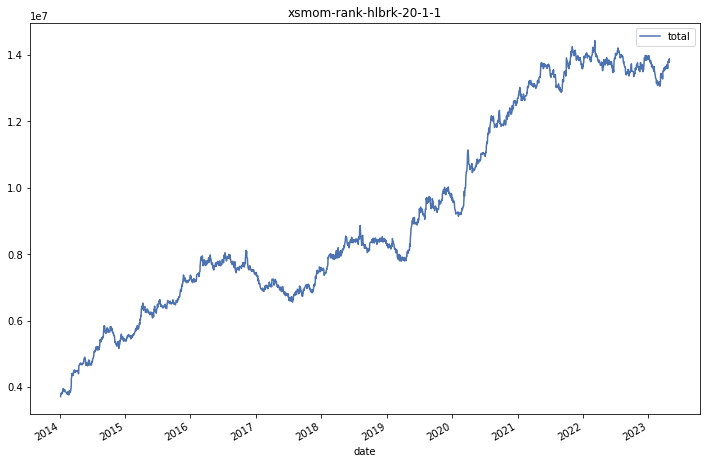

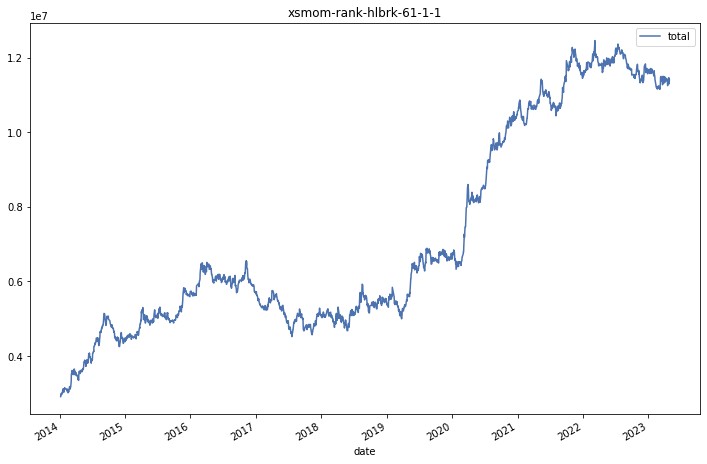

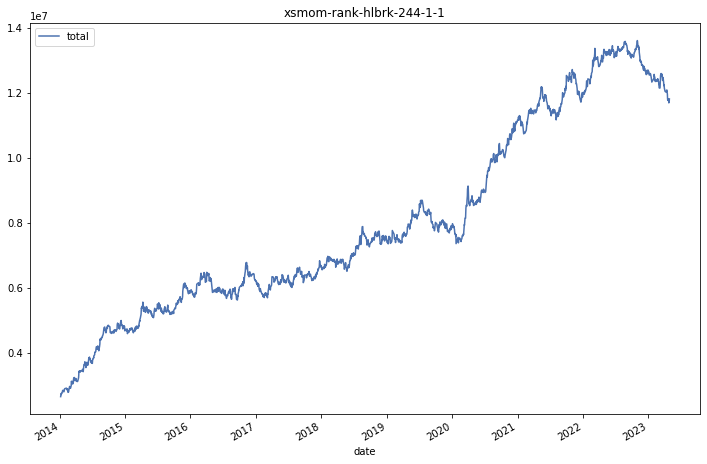

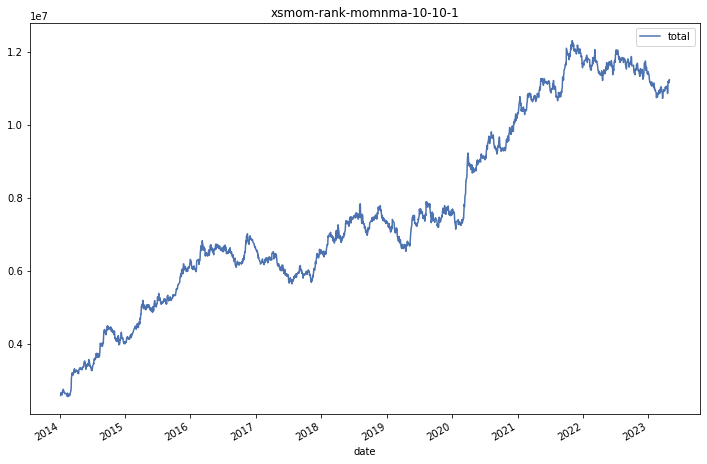

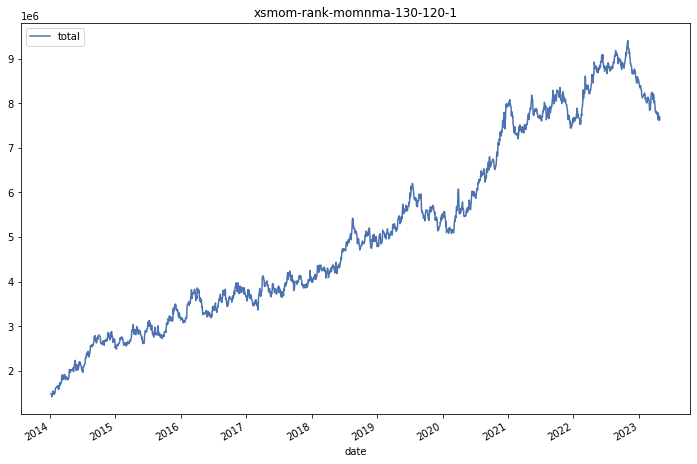

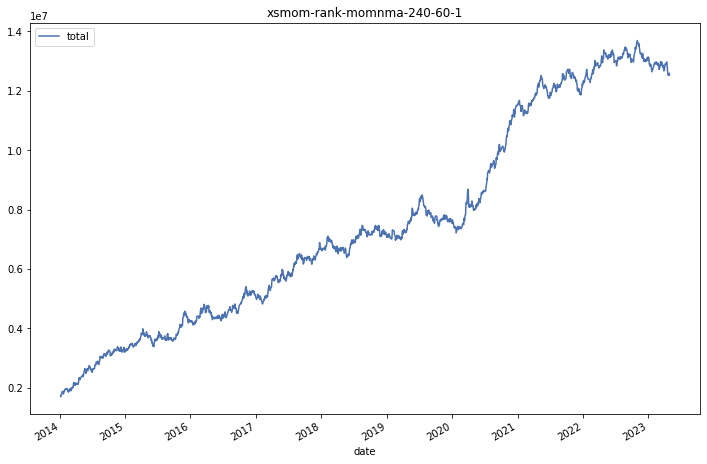

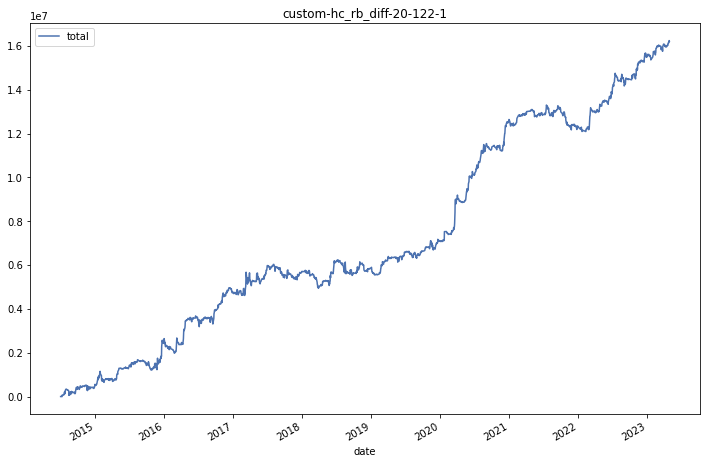

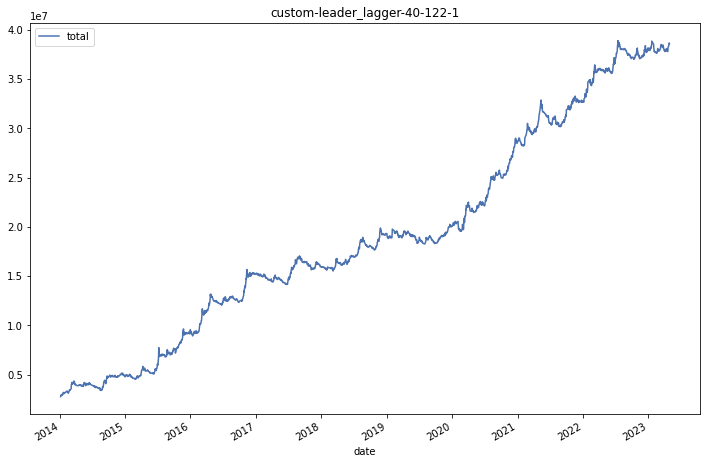

In [55]:
scen_start = pd.to_datetime('2014-01-01')
df_list = []
hot_key = 'hot_test'
for scen_name, scen_stat in zip(scen_names[hot_key], scen_stats[hot_key]):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names[hot_key]
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
